# Projet - Deep Learning

<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Auteur : </span>TOURE Boubacar (<a href="boubacar.toure@etud.univ-angers.fr">boubacar.toure@etud.univ-angers.fr</a>), étudiant en Master 2 Informatique à la faculté des sciences d'Angers</p>
<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Professeur Référent : </span>Sylvain Lamprier (<a href="sylvain.lamprier@univ-angers.fr">sylvain.lamprier@univ-angers.fr</a>)</p>

# Import du projet

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import zipfile
import tarfile
import shutil
import torch
import time
import os

from tqdm import tqdm
from torchvision import models
from tqdm.autonotebook import tqdm
from torch.utils.tensorboard import SummaryWriter

from torchvision.models import ResNet18_Weights
from torchvision.models import AlexNet_Weights
from torchvision.models import SqueezeNet1_0_Weights
from torchvision.models import VGG16_Weights
from torchvision.models import DenseNet161_Weights
from torchvision.models import Inception_V3_Weights

# --->  A DECOMMENTER LES INSTRUCTIONS CI-DESSOUS SUR GOOGLE COLAB  <---
# Installez wget, Pillow, PIL, image avec pip
!pip install wget
!pip install Pillow==7.2.0
!pip install image
from PIL import Image

# Importation de la bibliothèque wget
import wget

# Déclaration des fonctions 

In [8]:
def train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=8, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device is :", device)
    
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/project-train"):
        shutil.rmtree(f"/tmp/logs/project-train")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/project"
    
    summary = SummaryWriter(f"{TB_PATH}-{typeTrain}-train")
    
    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []
    
    start_time = time.time()
    print('\n', '-' * 40)
    for epoch in range(1, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        correct = 0.0
        total = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Inception_v3 specific code
            if typeTrain == "inception_v3":
                outputs, aux_outputs = model(images)
                loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
            else:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total
        accuraciesOfTrain.append(train_accuracy)
        summary.add_scalar("Accuracy_Of_Train", train_accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))

        if epoch % 2 == 0: 
            # Evaluation sur les données de test
            model.eval()
            with torch.no_grad():
                validation_loss = 0.0
                correct = 0.0
                total = 0.0
                for images, labels in validation_loader:
                    images, labels = images.to(device), labels.to(device)
                    # Inception_v3 specific code
                    if typeTrain == "inception_v3":
                        outputs, aux_outputs = model(images)
                        validation_loss += loss_fn(outputs, labels).item() + 0.3 * loss_fn(aux_outputs, labels).item()
                    else:
                        outputs = model(images)
                        validation_loss += loss_fn(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                
                print('\t', '-' * 40)
                print("\tPredicted :", predicted)
                print("\tResult :", labels)
                print("\tTOTAL (correct/total):", correct, '/', total)
                print('\t', '-' * 40)

                validation_loss = validation_loss/len(validation_loader)
                validation_accuracy = correct / total
                accuraciesOfValidation.append(validation_accuracy)
                summary.add_scalar("Accuracy_Of_Validation", validation_accuracy, epoch)
                summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
                validation_losses.append(validation_loss/len(validation_loader))

                print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f} %".format(epoch, validation_loss, validation_accuracy * 100.0, '\n'))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f} %".format(epoch, train_loss/len(train_loader), train_accuracy * 100.0))
    print('\n', '-' * 40)
    end_time = time.time()
    
    trainTime = end_time - start_time
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}-{typeTrain}-train
    
    return trainTime, trainModelComplexity, validation_loss, validation_accuracy, accuraciesOfValidation

def prepare_data(mean, std, size_of_image, transform, batch_size, split):
    # Chargement des données dans le dossier 101_ObjectCategories
    dataset = torchvision.datasets.ImageFolder(root='./101_ObjectCategories', transform=transform)
    
    # Chargement des données dans le dossier 101_ObjectCategories
    dataset = torchvision.datasets.ImageFolder(root='./101_ObjectCategories', transform=transform)

    # # Découpe des données en ensembles d'apprentissage et de test avec 90 % d'entrainement et 10 % de test de validation
    # train_size = int(split * len(dataset))
    # test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Usage de Subset pour la formation des données d'entrainement et de tests de validations
    indices = list(range(len(dataset)))
    split = int(split * len(dataset))
    train_indices = indices[:split]
    test_indices = indices[split:]
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Création des dataloaders pour les données d'entrainement et de tests de validations (via torch)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    
    return train_dataloader, test_dataloader

def prepare_data_on_google_colab(mean, std, size_of_image, transform, batch_size, split):
    # Téléchargez l'archive
    if not os.path.exists("caltech-101.zip"):
        url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
        wget.download(url)

    # Retirez le répertoire "101_ObjectCategories"
    if os.path.exists("101_ObjectCategories"):
        shutil.rmtree("101_ObjectCategories")
    
    with zipfile.ZipFile('caltech-101.zip', 'r') as zip_ref:
        zip_ref.extractall()

    with tarfile.open('caltech-101/101_ObjectCategories.tar.gz', "r:gz") as tar:
        tar.extractall()

    # Retirez le répertoire "caltech-101"
    if os.path.exists("caltech-101"):
        shutil.rmtree("caltech-101")

    # Retirez le répertoire "BACKGROUND_Google"
    if os.path.exists("101_ObjectCategories/BACKGROUND_Google"):
        shutil.rmtree("101_ObjectCategories/BACKGROUND_Google")

    print("La liste des fichiers du dossier '/content/' sur colab :", os.listdir())

    # Chargement des données dans le dossier 101_ObjectCategories
    dataset = torchvision.datasets.ImageFolder(root='./101_ObjectCategories', transform=transform)

    # Découpe des données en ensembles d'apprentissage et de test avec 90 % d'entrainement et 10 % de test de validation
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # # Usage de Subset pour la formation des données d'entrainement et de tests de validations
    # indices = list(range(len(dataset)))
    # split = int(split * len(dataset))
    # train_indices = indices[:split]
    # test_indices = indices[split:]
    # train_dataset = torch.utils.data.Subset(dataset, train_indices)
    # test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Création des dataloaders pour les données d'entrainement et de tests de validations (via torch)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    
    return train_dataloader, test_dataloader

def adapt_pretrained_model(model_name, num_classes=101):
    # Load the pretrained model
    if model_name == "resnet18":
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
    elif model_name == "squeezenet1_0":
        model = models.squeezenet1_0(weights=SqueezeNet1_0_Weights.IMAGENET1K_V1)
        model.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
    elif model_name == "vgg16":
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
    elif model_name == "densenet161":
        model = models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
        model.classifier = torch.nn.Linear(in_features=2208, out_features=num_classes, bias=True)
        model.num_classes = num_classes
    elif model_name == "inception_v3":
        model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Model not recognized")
    
    # freeze all model parameters
    for param in model.parameters():
        param.requiresGrad = False
    
    return model

def compare_models(executionTimeOfModel1, complexityOfModel1, validationLossOfModel1, accuracyOfModel1, executionTimeOfModel2, complexityOfModel2, validationLossOfModel2, accuracyOfModel2):
    print("Le modèle 1 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel1, accuracyOfModel1*100.0, complexityOfModel1, executionTimeOfModel1))
    print("\nLe modèle 2 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel2, accuracyOfModel2*100.0, complexityOfModel2, executionTimeOfModel2))

    if validationLossOfModel1 < validationLossOfModel2:
        print("\n\tLe modèle 1 a une perte plus faible sur les données de validation.")
        return 1
    else:
        print("\n\tLe modèle 2 a une perte plus faible sur les données de validation.")
        return 2

def affiche_dataloader(dataloader):
    for i, data in enumerate(dataloader):
        if i <= 10:
            images, labels = data
            print("Image Shape: ", images.shape)
            print("Label Shape: ", labels.shape)
        else:
            break

# Chargement des données du projet

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
size_of_image = [224, 224]

batch_size = 16
split = 0.9
epochs = 8

transform = transforms.Compose([
    transforms.Resize(size_of_image),
    transforms.CenterCrop(size_of_image),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# train_dataloader, test_dataloader = prepare_data(mean, std, size_of_image, transform, batch_size, split)
train_dataloader, test_dataloader = prepare_data_on_google_colab(mean, std, size_of_image, transform, batch_size, split)

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']


# Entrainement et chargement des modèles 

## Test sur les jeux de données en utilisant le séparateur **<< torch.utils.data.Subset >>**

### Le modèle << resnet18 >> avec l'optimiseur : Adam

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.9346, Train Accuracy: 54.7061 %
	 ----------------------------------------
	Predicted : tensor([69, 70,  1,  2], device='cuda:0')
	Result : tensor([92, 94, 94, 97], device='cuda:0')
	TOTAL (correct/total): 13.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 16.1665, Validation Accuracy: 1.4977 %
Epoch 3, Train Loss: 0.5070, Train Accuracy: 86.0417 %
	 ----------------------------------------
	Predicted : tensor([84, 17, 82, 21], device='cuda:0')
	Result : tensor([100,  94,  90,  92], device='cuda:0')
	TOTAL (correct/total): 14.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 16.7408, Validation Accuracy: 1.6129 %
Epoch 5, Train Loss: 0.1921, Train Accuracy: 94.8137 %
	 ----------------------------------------
	Predicted : tensor([56, 18, 23, 12], device='cuda:0')
	Result : tensor([93, 94, 94, 95], device='cuda:0')
	TOTAL (correct/total): 14.

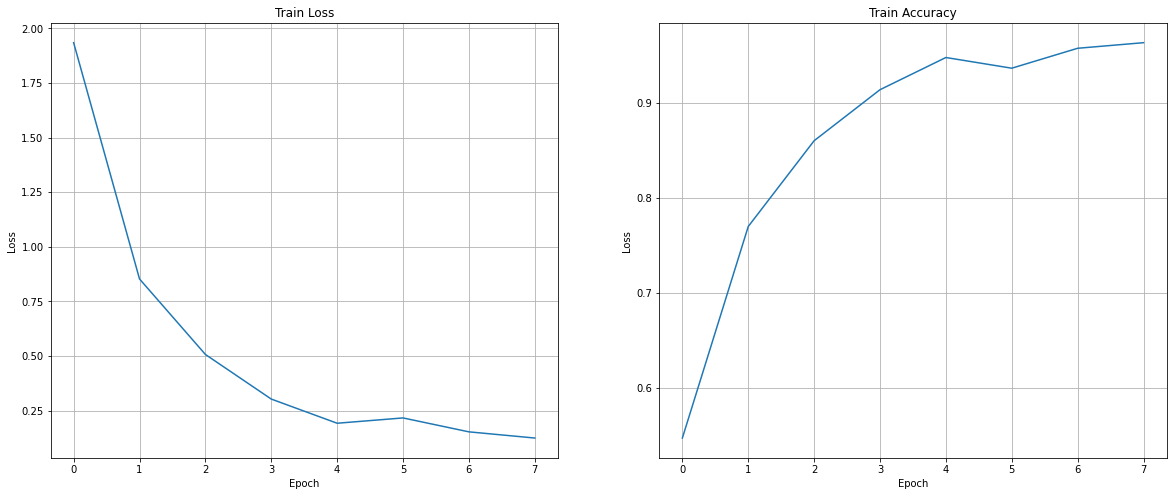

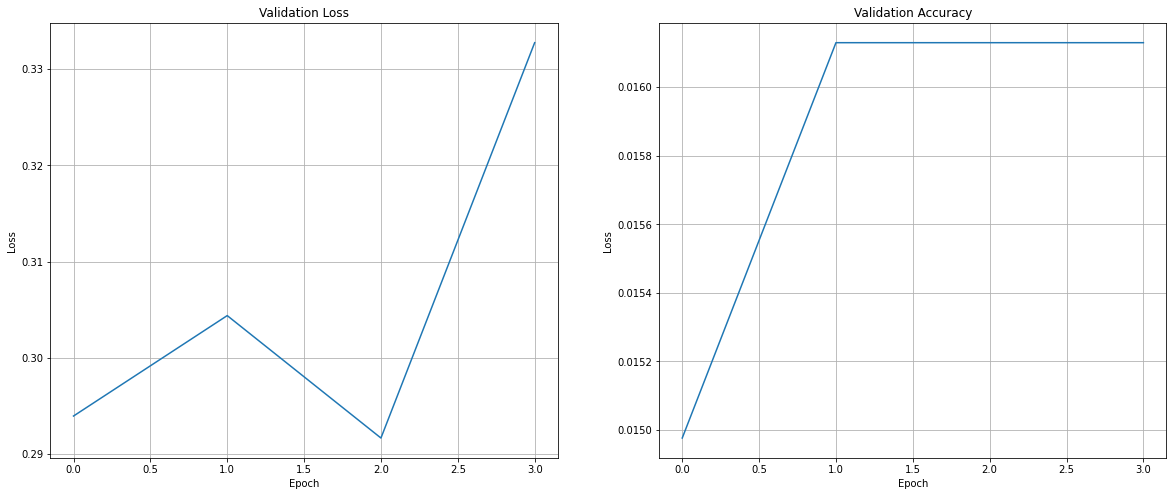

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
modelAdam_resnet18 = adapt_pretrained_model("resnet18")
loss_fn = nn.CrossEntropyLoss()
optimiseurAdam_resnet18 = torch.optim.Adam(modelAdam_resnet18.parameters(), lr=0.001)
modelAdam_resnet18_trainTime, modelAdam_resnet18_trainModelComplexity, modelAdam_resnet18_validation_loss, modelAdam_resnet18_accuracy, _ = train(modelAdam_resnet18, train_dataloader, test_dataloader, loss_fn, optimiseurAdam_resnet18, epochs, typeTrain="resnet18-Adam")

### Le modèle << resnet18 >> avec l'optimiseur : SGD

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.7773, Train Accuracy: 57.8179 %
	 ----------------------------------------
	Predicted : tensor([16, 60, 65, 47], device='cuda:0')
	Result : tensor([96, 95, 92, 95], device='cuda:0')
	TOTAL (correct/total): 14.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 16.5837, Validation Accuracy: 1.6129 %
Epoch 3, Train Loss: 0.4382, Train Accuracy: 87.5784 %
	 ----------------------------------------
	Predicted : tensor([63, 72, 39, 60], device='cuda:0')
	Result : tensor([94, 89, 91, 95], device='cuda:0')
	TOTAL (correct/total): 13.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 16.0259, Validation Accuracy: 1.4977 %
Epoch 5, Train Loss: 0.2120, Train Accuracy: 94.2118 %
	 ----------------------------------------
	Predicted : tensor([72, 61, 61, 23], device='cuda:0')
	Result : tensor([94, 99, 99, 96], device='cuda:0')
	TOTAL (correct/total): 14.0 / 

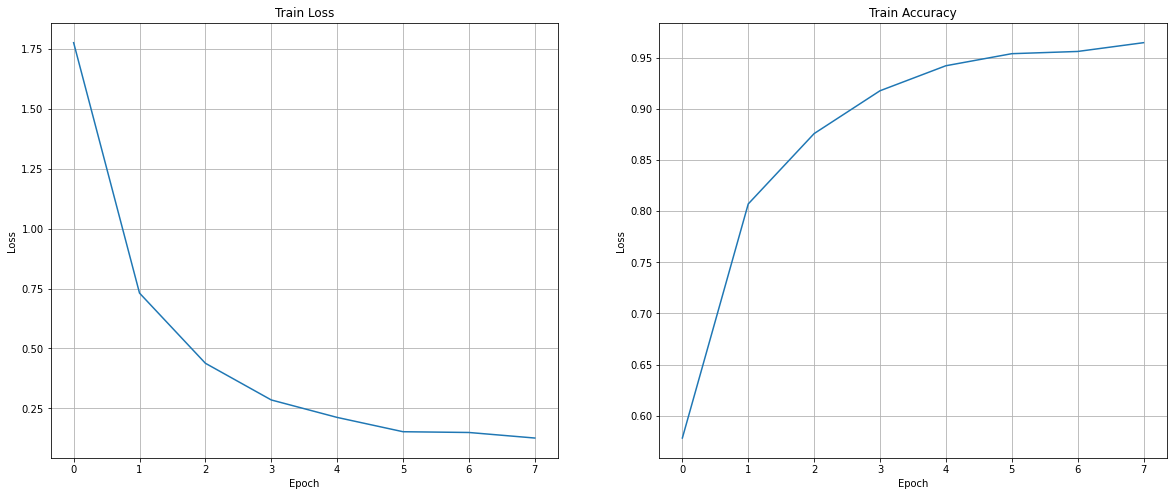

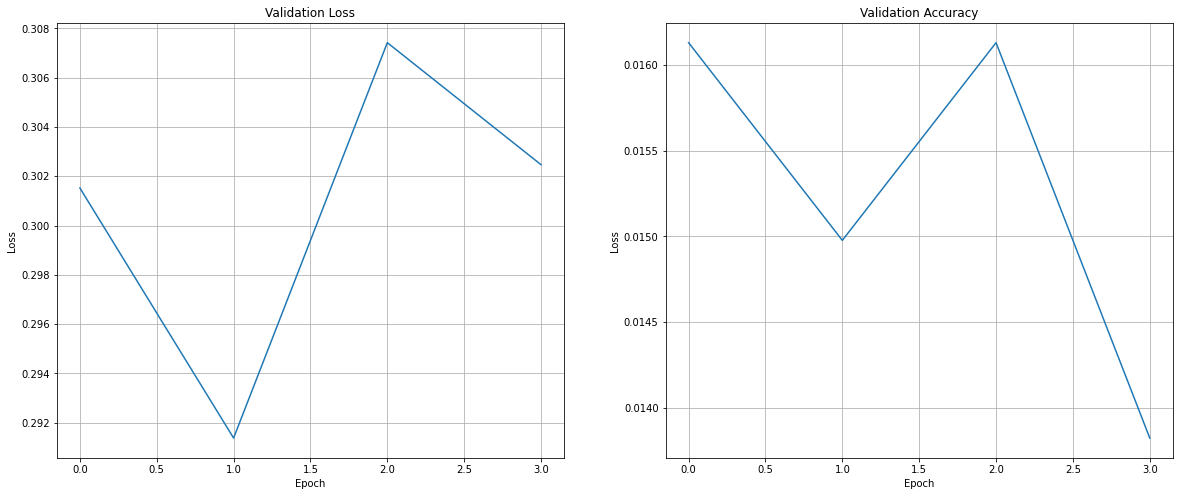

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
modelSGD_resnet18 = adapt_pretrained_model("resnet18")
loss_fn = nn.CrossEntropyLoss()
optimiseurSGD_resnet18 = torch.optim.Adam(modelSGD_resnet18.parameters(), lr=0.001)
modelSGD_resnet18_trainTime, modelSGD_resnet18_trainModelComplexity, modelSGD_resnet18_validation_loss, modelSGD_resnet18_accuracy, _ = train(modelSGD_resnet18, train_dataloader, test_dataloader, loss_fn, optimiseurSGD_resnet18, epochs, typeTrain="resnet18-SGD")

### Comparaison : resnet18Adam VS resnet18SGD

In [ ]:
resultTest1 = compare_models(modelAdam_resnet18_trainTime, modelAdam_resnet18_trainModelComplexity, modelAdam_resnet18_validation_loss, modelAdam_resnet18_accuracy, modelSGD_resnet18_trainTime, modelSGD_resnet18_trainModelComplexity, modelSGD_resnet18_validation_loss, modelSGD_resnet18_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle resnet18 avec Adam est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle resnet18 avec SGD est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 18.301277299360795 sur les données de validation avec une précision de 1.6129032258064515% et une complexité de 11228325 paramètres et un temps d'évaluation de 428.42567563056946s

Le modèle 2 a une perte de 16.63567485809326 sur les données de validation avec une précision de 1.3824884792626728% et une complexité de 11228325 paramètres et un temps d'évaluation de 448.3988983631134s

	Le modèle 2 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle resnet18 avec SGD est le plus performant !
___________________________________________________



### Conclusion : 

A la suite de nombreux tests que nous avons eu à réaliser en utilisant **"torch.utils.data.Subset"**. Nous pouvons conclure que lors des séances d'entrainement de nos modèles, nous avons de très bon résultats. Par contre, lorsque nous passons à la phase de validation. Nous remarquons que nous obtenons de très mauvaises prédictions des données de sorties (Avoir sur l'image ci-dessus). D'où l'obtention d'un faible pourcentage d'accuracy (1.6129 % et 1.3825 %) pour le modèles resnet18 utilisant respectivement l'optimiseur Adam et SGD.

De plus, nous pouvons remarquer que l'usage de l'optimiseur SGD est le plus adapté pour la réalisation de nos tests. Voilà pourquoi, pour tous les tests que nous allons faire à partir de maintenant. **L'optimiseur SGD sera prioritaire**.

## Test sur les jeux de données en utilisant le séparateur **<< torch.utils.data.random_split >>**

### Le modèle << resnet18 >> avec l'optimiseur : SGD

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.8867, Train Accuracy: 63.5677 %
	 ----------------------------------------
	Predicted : tensor([32, 20,  1, 12], device='cuda:0')
	Result : tensor([32, 20,  1, 12], device='cuda:0')
	TOTAL (correct/total): 828.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.2472, Validation Accuracy: 95.3917 %
Epoch 3, Train Loss: 0.2380, Train Accuracy: 96.9778 %
	 ----------------------------------------
	Predicted : tensor([ 0, 68, 90, 55], device='cuda:0')
	Result : tensor([ 0, 68, 90, 55], device='cuda:0')
	TOTAL (correct/total): 835.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1536, Validation Accuracy: 96.1982 %
Epoch 5, Train Loss: 0.0947, Train Accuracy: 99.2957 %
	 ----------------------------------------
	Predicted : tensor([22, 16, 12, 56], device='cuda:0')
	Result : tensor([22, 16, 12, 56], device='cuda:0')
	TOTAL (correct/total): 838.0

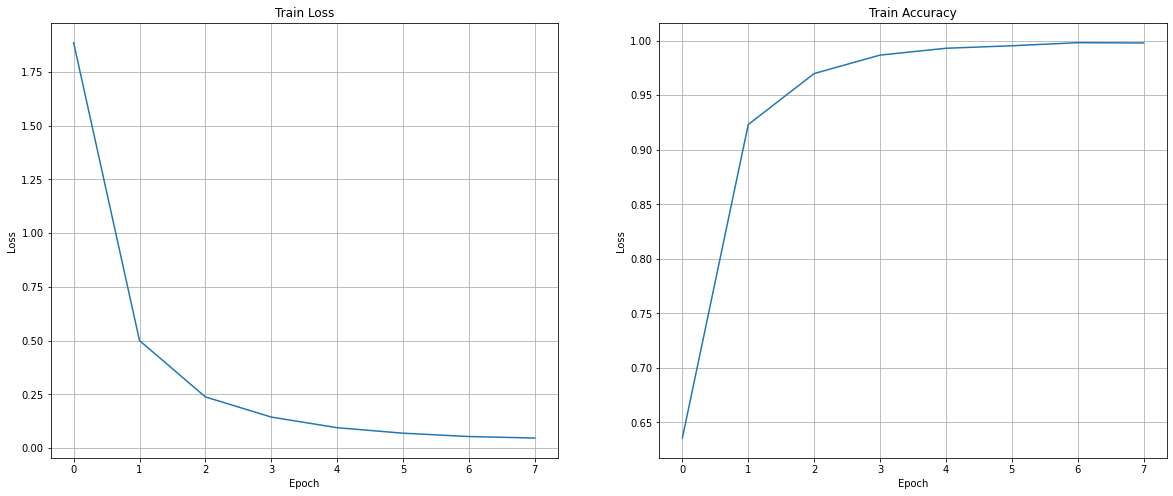

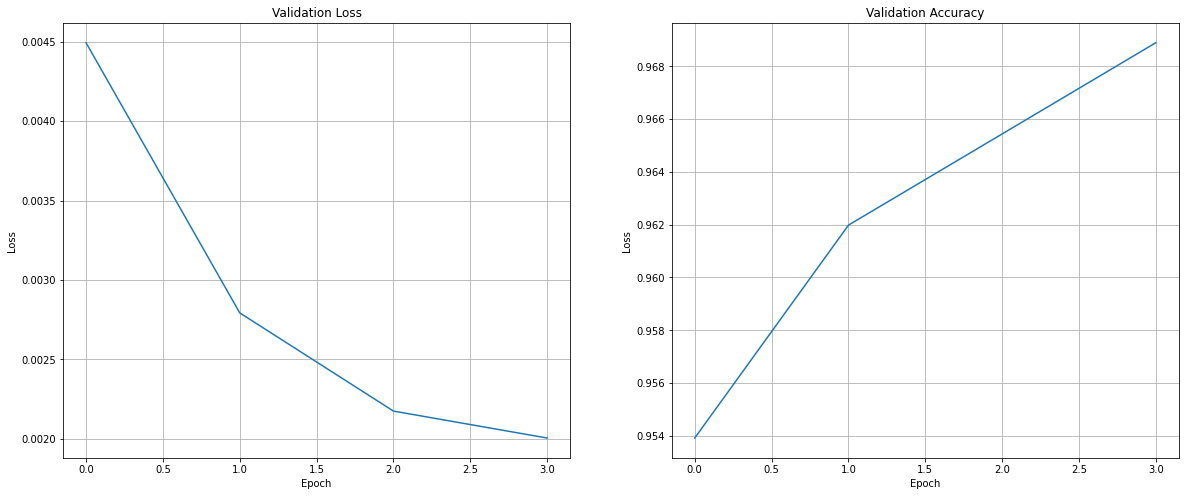

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
model_resnet18 = adapt_pretrained_model("resnet18")
loss_fn = nn.CrossEntropyLoss()
optimiseur_resnet18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)
model_resnet18_trainTime, model_resnet18_trainModelComplexity, model_resnet18_validation_loss, model_resnet18_accuracy, _ = train(model_resnet18, train_dataloader, test_dataloader, loss_fn, optimiseur_resnet18, epochs, typeTrain="resnet18")

### Le modèle << alexnet >> avec l'optimiseur : SGD

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.1689, Train Accuracy: 72.2244 %
	 ----------------------------------------
	Predicted : tensor([29,  5, 19, 23], device='cuda:0')
	Result : tensor([29,  5, 19, 23], device='cuda:0')
	TOTAL (correct/total): 772.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4188, Validation Accuracy: 88.9401 %
Epoch 3, Train Loss: 0.1729, Train Accuracy: 94.8009 %
	 ----------------------------------------
	Predicted : tensor([ 5, 57, 23,  0], device='cuda:0')
	Result : tensor([ 5, 57, 23,  0], device='cuda:0')
	TOTAL (correct/total): 775.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4178, Validation Accuracy: 89.2857 %
Epoch 5, Train Loss: 0.1273, Train Accuracy: 96.1967 %
	 ----------------------------------------
	Predicted : tensor([40, 40, 75, 93], device='cuda:0')
	Result : tensor([40, 40, 75, 93], device='cuda:0')
	TOTAL (correct/total): 788.0

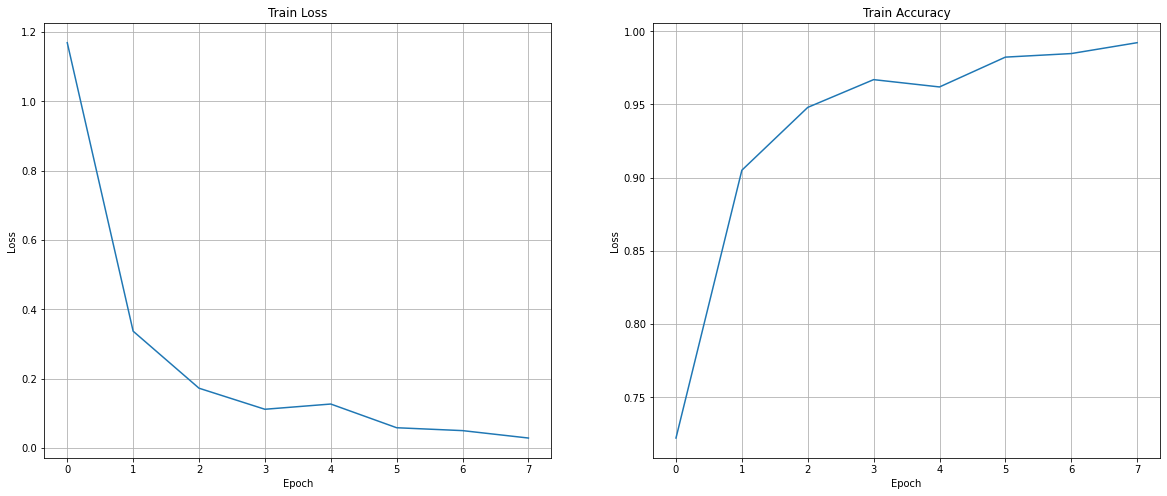

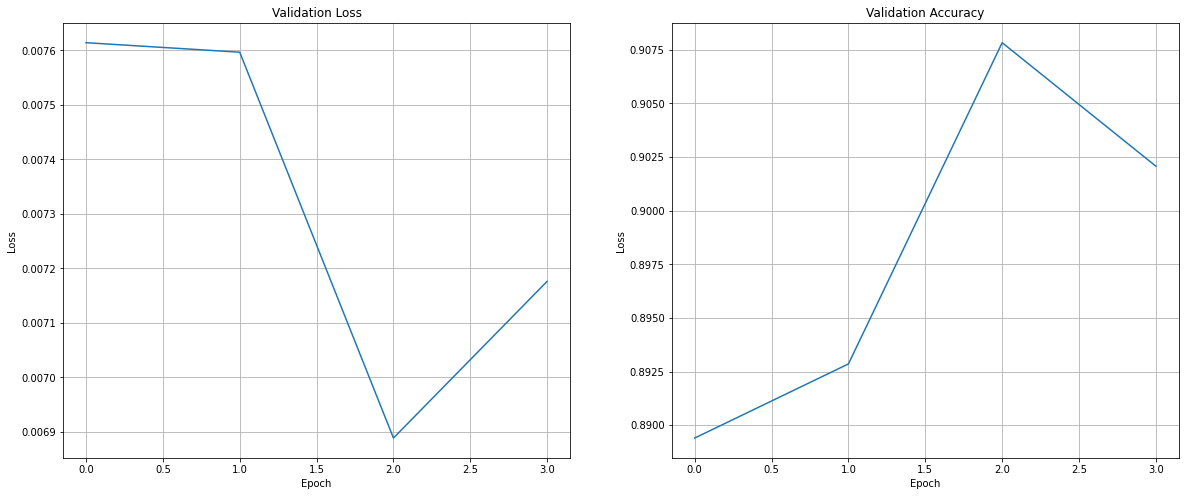

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 35388), started 0:13:47 ago. (Use '!kill 35388' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
model_alexnet = adapt_pretrained_model("alexnet")
loss_fn = nn.CrossEntropyLoss()
optimiseur_alexnet = torch.optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)
model_alexnet_trainTime, model_alexnet_trainModelComplexity, model_alexnet_validation_loss, model_alexnet_accuracy, _ = train(model_alexnet, train_dataloader, test_dataloader, loss_fn, optimiseur_alexnet, epochs, typeTrain="alexnet")

### Le modèle << squeezenet1_0 >> avec l'optimiseur : SGD

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 2.0085, Train Accuracy: 55.1159 %
	 ----------------------------------------
	Predicted : tensor([73, 81,  5, 75], device='cuda:0')
	Result : tensor([73, 81,  5, 75], device='cuda:0')
	TOTAL (correct/total): 705.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.7157, Validation Accuracy: 81.2212 %
Epoch 3, Train Loss: 0.5398, Train Accuracy: 85.0813 %
	 ----------------------------------------
	Predicted : tensor([94, 92,  3, 63], device='cuda:0')
	Result : tensor([94, 92,  3, 63], device='cuda:0')
	TOTAL (correct/total): 748.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4445, Validation Accuracy: 86.1751 %
Epoch 5, Train Loss: 0.2783, Train Accuracy: 91.8812 %
	 ----------------------------------------
	Predicted : tensor([19, 24, 29, 48], device='cuda:0')
	Result : tensor([19, 24, 29, 48], device='cuda:0')
	TOTAL (correct/total): 751.0

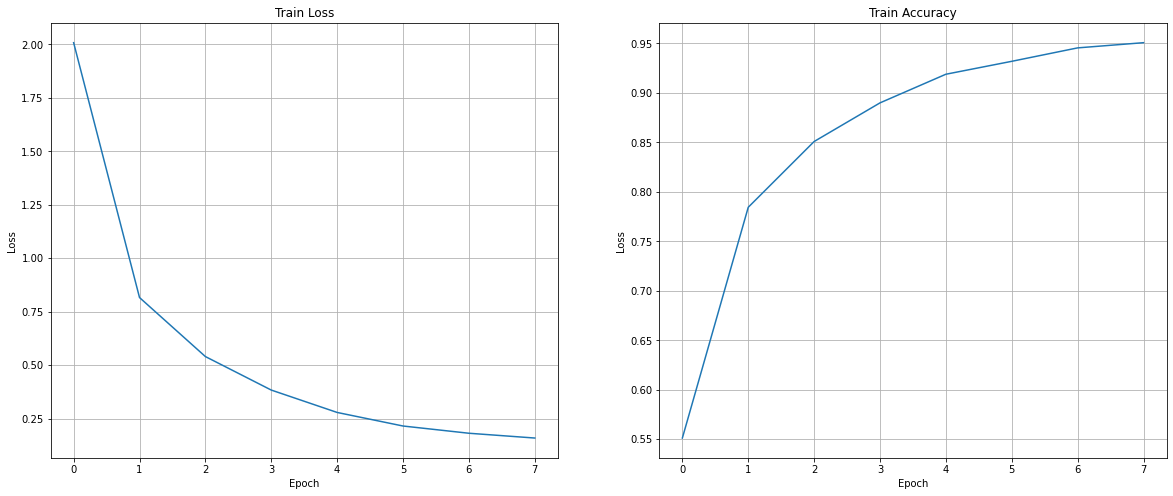

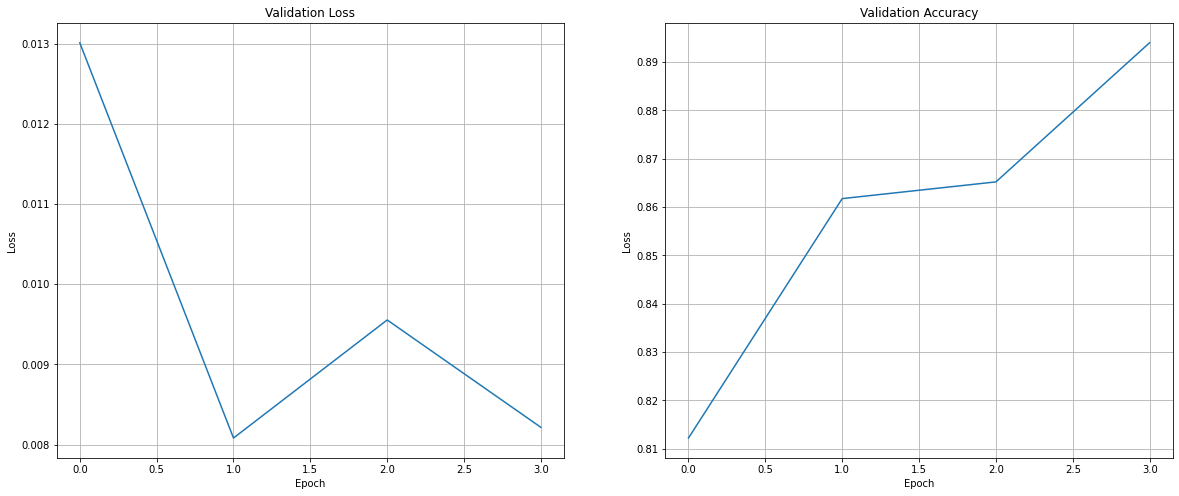

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
model_squeezenet1_0 = adapt_pretrained_model("squeezenet1_0")
loss_fn = nn.CrossEntropyLoss()
optimiseur_squeezenet1_0 = torch.optim.SGD(model_squeezenet1_0.parameters(), lr=0.001, momentum=0.9)
model_squeezenet1_0_trainTime, model_squeezenet1_0_trainModelComplexity, model_squeezenet1_0_validation_loss, model_squeezenet1_0_accuracy, _ = train(model_squeezenet1_0, train_dataloader, test_dataloader, loss_fn, optimiseur_squeezenet1_0, epochs, typeTrain="squeezenet1_0")

### Le modèle << vgg16 >> avec l'optimiseur : SGD

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.0139, Train Accuracy: 75.6307 %
	 ----------------------------------------
	Predicted : tensor([64,  0, 63, 46], device='cuda:0')
	Result : tensor([64,  0, 63, 46], device='cuda:0')
	TOTAL (correct/total): 808.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.2524, Validation Accuracy: 93.0876 %
Epoch 3, Train Loss: 0.1759, Train Accuracy: 94.9417 %
	 ----------------------------------------
	Predicted : tensor([81,  3,  3, 73], device='cuda:0')
	Result : tensor([81,  3,  3, 73], device='cuda:0')
	TOTAL (correct/total): 820.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1803, Validation Accuracy: 94.4700 %
Epoch 5, Train Loss: 0.0502, Train Accuracy: 98.7450 %
	 ----------------------------------------
	Predicted : tensor([12, 18, 18, 57], device='cuda:0')
	Result : tensor([12, 18, 18, 57], device='cuda:0')
	TOTAL (correct/total): 824.0

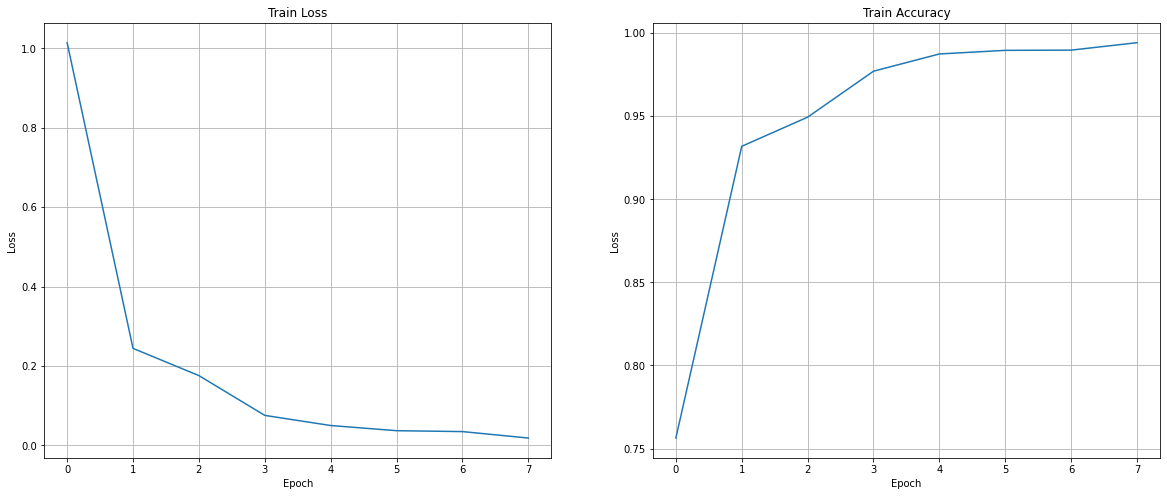

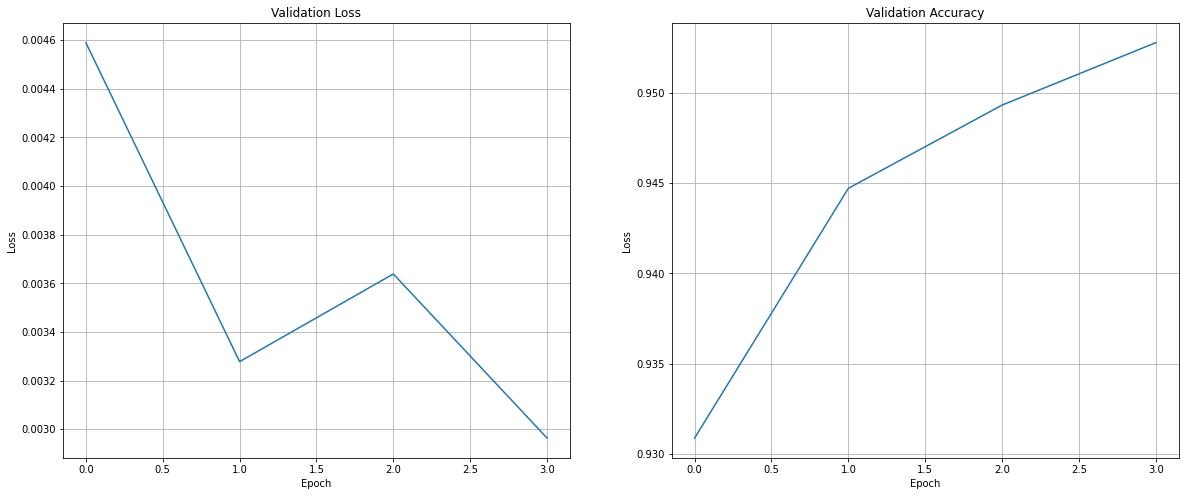

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
model_vgg16 = adapt_pretrained_model("vgg16")
loss_fn = nn.CrossEntropyLoss()
optimiseur_vgg16 = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
model_vgg16_trainTime, model_vgg16_trainModelComplexity, model_vgg16_validation_loss, model_vgg16_accuracy, _ = train(model_vgg16, train_dataloader, test_dataloader, loss_fn, optimiseur_vgg16, epochs, typeTrain="vgg16")

### Le modèle << densenet161 >> avec l'optimiseur : SGD

Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.6695, Train Accuracy: 68.3698 %
	 ----------------------------------------
	Predicted : tensor([ 3,  0, 51, 75], device='cuda:0')
	Result : tensor([ 3,  0, 51, 18], device='cuda:0')
	TOTAL (correct/total): 833.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1556, Validation Accuracy: 95.9677 %
Epoch 3, Train Loss: 0.1256, Train Accuracy: 98.6042 %
	 ----------------------------------------
	Predicted : tensor([22, 40, 23, 47], device='cuda:0')
	Result : tensor([22, 40, 23, 47], device='cuda:0')
	TOTAL (correct/total): 841.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.0990, Validation Accuracy: 96.8894 %
Epoch 5, Train Loss: 0.0546, Train Accuracy: 99.5518 %
	 ----------------------------------------
	Predicted : tensor([94,  3, 86, 74], device='cuda:0')
	Result : tensor([94,  3, 86, 74], device='cuda:0')
	TOTAL (correct/total): 841.0

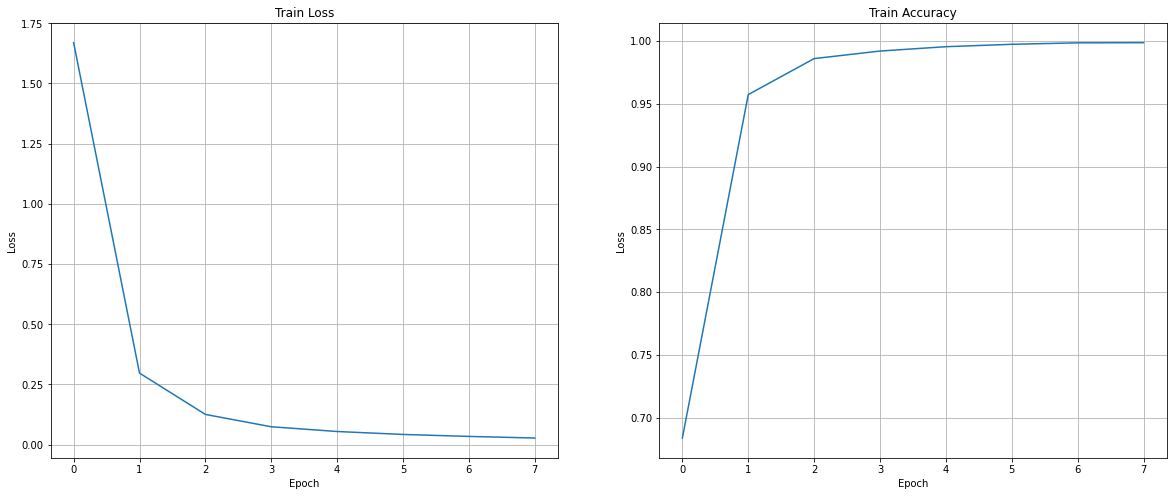

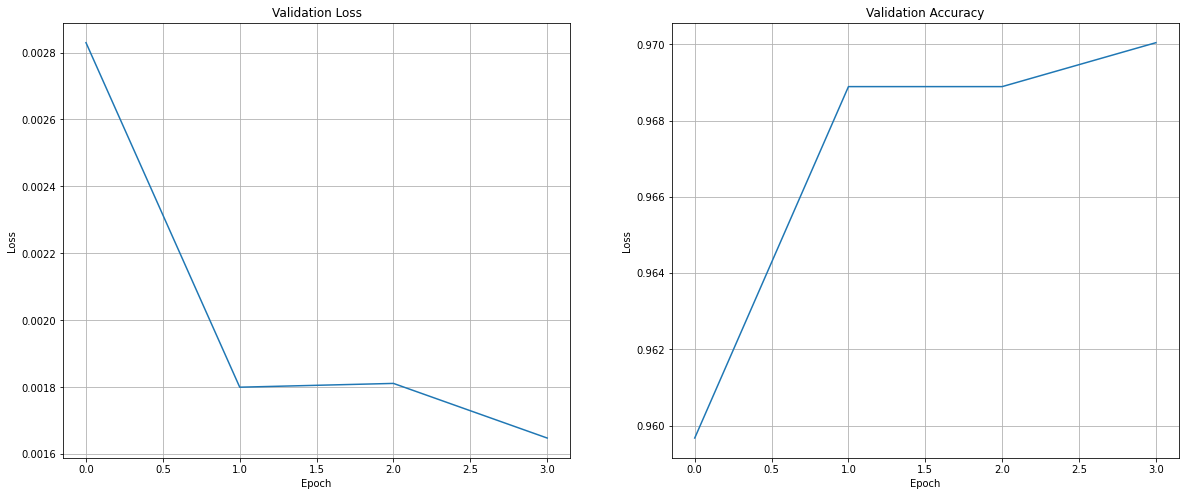

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16904), started 0:29:00 ago. (Use '!kill 16904' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
model_densenet161 = adapt_pretrained_model("densenet161")
loss_fn = nn.CrossEntropyLoss()
optimiseur_densenet161 = torch.optim.SGD(model_densenet161.parameters(), lr=0.001, momentum=0.9)
model_densenet161_trainTime, model_densenet161_trainModelComplexity, model_densenet161_validation_loss, model_densenet161_accuracy, _ = train(model_densenet161, train_dataloader, test_dataloader, loss_fn, optimiseur_densenet161, epochs, typeTrain="densenet161")

### Le modèle << inception_v3 >> avec l'optimiseur : SGD

In [ ]:
size_of_image = [299, 299]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(size_of_image),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

affiche_dataloader(test_dataloader)

# train_dataloader, test_dataloader = prepare_data(mean, std, size_of_image, transform, batch_size, split)
train_dataloader, test_dataloader = prepare_data_on_google_colab(mean, std, size_of_image, transform, batch_size, split)

affiche_dataloader(test_dataloader)

In [ ]:
model_inception_v3 = adapt_pretrained_model("inception_v3")
loss_fn = nn.CrossEntropyLoss()
optimiseur_inception_v3 = torch.optim.SGD(model_inception_v3.parameters(), lr=0.001, momentum=0.9)
model_inception_v3_trainTime, model_inception_v3_trainModelComplexity, model_inception_v3_validation_loss, model_inception_v3_accuracy, _ = train(model_inception_v3, train_dataloader, test_dataloader, loss_fn, optimiseur_inception_v3, epochs, typeTrain="inception_v3")

### Comparaison des modèles

#### Pour : resnet18 VS alexnet

In [ ]:
resultTest1 = compare_models(model_resnet18_trainTime, model_resnet18_trainModelComplexity, model_resnet18_validation_loss, model_resnet18_accuracy, model_alexnet_trainTime, model_alexnet_trainModelComplexity, model_alexnet_validation_loss, model_alexnet_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle resnet18 est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle alexnet est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 0.11028738759288734 sur les données de validation avec une précision de 96.88940092165899% et une complexité de 11228325 paramètres et un temps d'évaluation de 402.37937355041504s

Le modèle 2 a une perte de 0.5426071947228841 sur les données de validation avec une précision de 87.44239631336406% et une complexité de 57417637 paramètres et un temps d'évaluation de 332.8651807308197s

	Le modèle 1 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle resnet18 est le plus performant !
___________________________________________________



#### Pour : squeezenet1_0 VS vgg16

In [ ]:
resultTest1 = compare_models(model_squeezenet1_0_trainTime, model_squeezenet1_0_trainModelComplexity, model_squeezenet1_0_validation_loss, model_squeezenet1_0_accuracy, model_vgg16_trainTime, model_vgg16_trainModelComplexity, model_vgg16_validation_loss, model_vgg16_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle squeezenet1_0 est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle vgg16 est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 0.45181643231348556 sur les données de validation avec une précision de 89.40092165898618% et une complexité de 787237 paramètres et un temps d'évaluation de 386.37032771110535s

Le modèle 2 a une perte de 0.16299629464880458 sur les données de validation avec une précision de 95.27649769585254% et une complexité de 134674341 paramètres et un temps d'évaluation de 1206.786409854889s

	Le modèle 2 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle vgg16 est le plus performant !
___________________________________________________



#### Pour : alexnet VS squeezenet1_0

In [ ]:
resultTest1 = compare_models(model_alexnet_trainTime, model_alexnet_trainModelComplexity, model_alexnet_validation_loss, model_alexnet_accuracy, model_squeezenet1_0_trainTime, model_squeezenet1_0_trainModelComplexity, model_squeezenet1_0_validation_loss, model_squeezenet1_0_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle alexnet est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle squeezenet1_0 est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 0.3947000590237704 sur les données de validation avec une précision de 90.2073732718894% et une complexité de 57417637 paramètres et un temps d'évaluation de 336.2233576774597s

Le modèle 2 a une perte de 0.45181643231348556 sur les données de validation avec une précision de 89.40092165898618% et une complexité de 787237 paramètres et un temps d'évaluation de 386.37032771110535s

	Le modèle 1 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle alexnet est le plus performant !
___________________________________________________



#### Pour : resnet18 VS vgg16

In [ ]:
resultTest1 = compare_models(model_resnet18_trainTime, model_resnet18_trainModelComplexity, model_resnet18_validation_loss, model_resnet18_accuracy, model_vgg16_trainTime, model_vgg16_trainModelComplexity, model_vgg16_validation_loss, model_vgg16_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle resnet18 est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle vgg16 est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 0.11028738759288734 sur les données de validation avec une précision de 96.88940092165899% et une complexité de 11228325 paramètres et un temps d'évaluation de 402.37937355041504s

Le modèle 2 a une perte de 0.16299629464880458 sur les données de validation avec une précision de 95.27649769585254% et une complexité de 134674341 paramètres et un temps d'évaluation de 1206.786409854889s

	Le modèle 1 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle resnet18 est le plus performant !
___________________________________________________



#### Pour : resnet18 VS densenet161

In [ ]:
resultTest1 = compare_models(model_resnet18_trainTime, model_resnet18_trainModelComplexity, model_resnet18_validation_loss, model_resnet18_accuracy, model_densenet161_trainTime, model_densenet161_trainModelComplexity, model_densenet161_validation_loss, model_densenet161_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle resnet18 est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle densenet161 est le plus performant !\n___________________________________________________\n")

Le modèle 1 a une perte de 0.11028738759288734 sur les données de validation avec une précision de 96.88940092165899% et une complexité de 11228325 paramètres et un temps d'évaluation de 402.37937355041504s

Le modèle 2 a une perte de 0.09065190162933008 sur les données de validation avec une précision de 97.00460829493088% et une complexité de 26695109 paramètres et un temps d'évaluation de 1688.1252143383026s

	Le modèle 2 a une perte plus faible sur les données de validation.

___________________________________________________
Le Modèle densenet161 est le plus performant !
___________________________________________________



#### Pour : densenet161 VS inception_v3

In [ ]:
resultTest1 = compare_models(model_densenet161_trainTime, model_densenet161_trainModelComplexity, model_densenet161_validation_loss, model_densenet161_accuracy, model_inception_v3_trainTime, model_inception_v3_trainModelComplexity, model_inception_v3_validation_loss, model_inception_v3_accuracy)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle densenet161 est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle inception_v3 est le plus performant !\n___________________________________________________\n")

# Conlusion

Nous pouvons donc conclure que parmi les cinq (5) modèles suivant : resnet18, alexnet, squeezenet1_0, vgg16 et densenet161. Le modèle le plus performant par ordre croissant est : 
*   densenet161 (1er)
*   resnet18 (2e)
*   alexnet (3e)
*   vgg16 (4e)
*   squeezenet1_0 (5e)

**N.B.** inception_v3 (???)

Concernant le modèle Inception_v3, dû à une faible puissant de mon GPU, je n'ai pas reussi à le tester. Pour pouvoir procéder au test, il me fallait payer un abonnement sur Google Colab afin d'avoir les ressources nécessaires pour permettre l'exécution de ma fonction train.

# Exécution des boucles d'apprentissage pour k itération

In [5]:
def boucle_de_validation_croisee_pour_k_iteration(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain="deepLearning", k=10):
    scores_total = []
    for i in range(k):
        # train_dataloader, test_dataloader = prepare_data(mean, std, size_of_image, transform, batch_size, split)
        train_dataloader, test_dataloader = prepare_data_on_google_colab(mean, std, size_of_image, transform, batch_size, split)

        # Apprentissage des données sur le Train et la Validation
        _, _, _, _, scores = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain="deepLearning")
        scores_total += scores
    
    # Calcul de la moyenne des scores sur les k itérations
    mean_score = sum(scores_total) / k
    print("La moyenne des accuracy: {:.4f} %".format(mean_score * 100.0))
    return mean_score

## Pour le modèle resnet18 avec K = 10

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.8704, Train Accuracy: 63.5933 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 819.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.2757, Validation Accuracy: 94.3548 %
Epoch 3, Train Loss: 0.2413, Train Accuracy: 96.9778 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 831.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1669, Validation Accuracy: 95.7373 %
Epoch 5, Train Loss: 0.0936, Train Accuracy: 99.2829 %
	 --------------------------------------

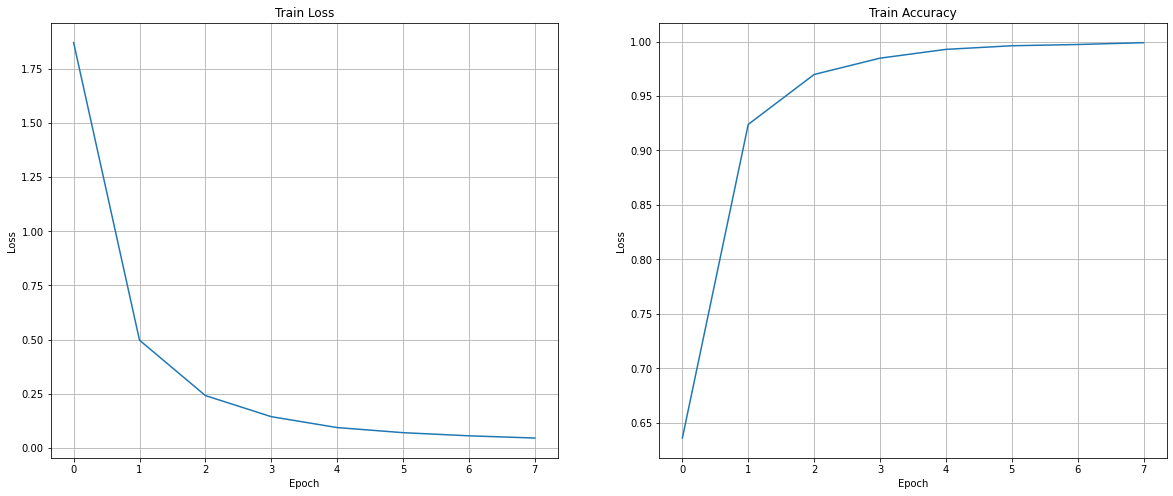

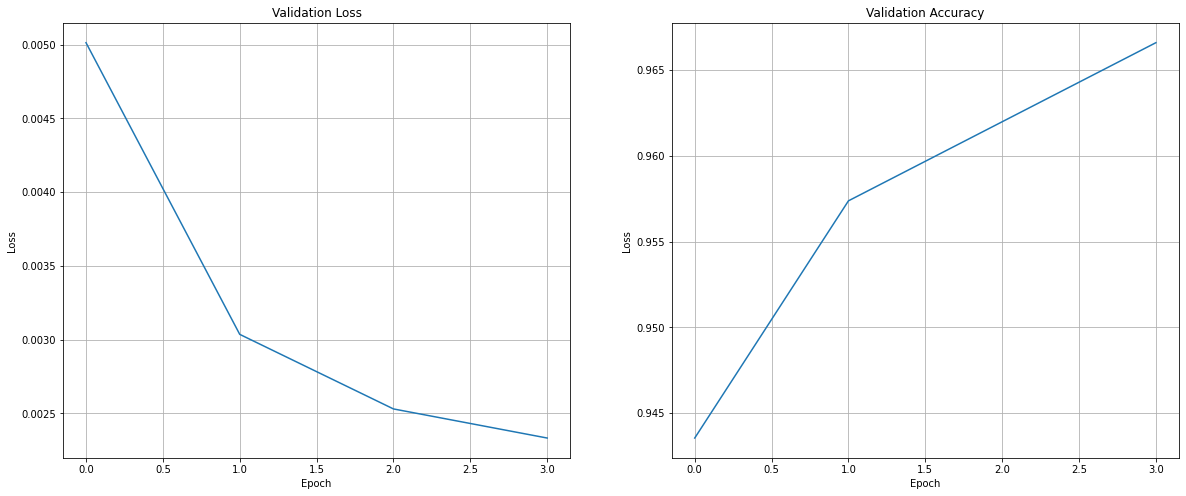

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0395, Train Accuracy: 99.8335 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1266, Validation Accuracy: 96.7742 %
Epoch 3, Train Loss: 0.0304, Train Accuracy: 99.8976 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 842.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1229, Validation Accuracy: 97.0046 %
Epoch 5, Train Loss: 0.0263, Train Accuracy: 99.9104 %
	 --------------------------------------

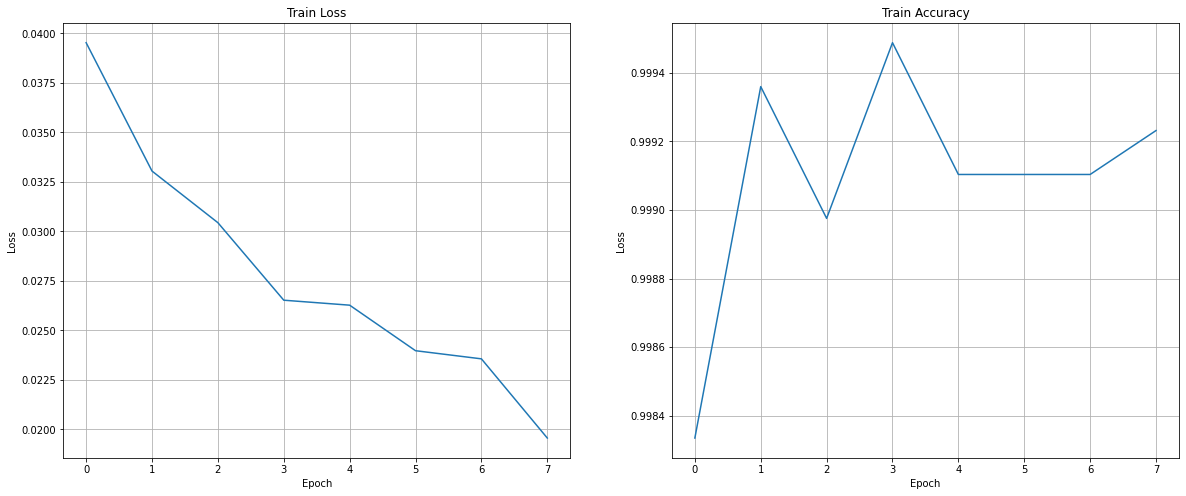

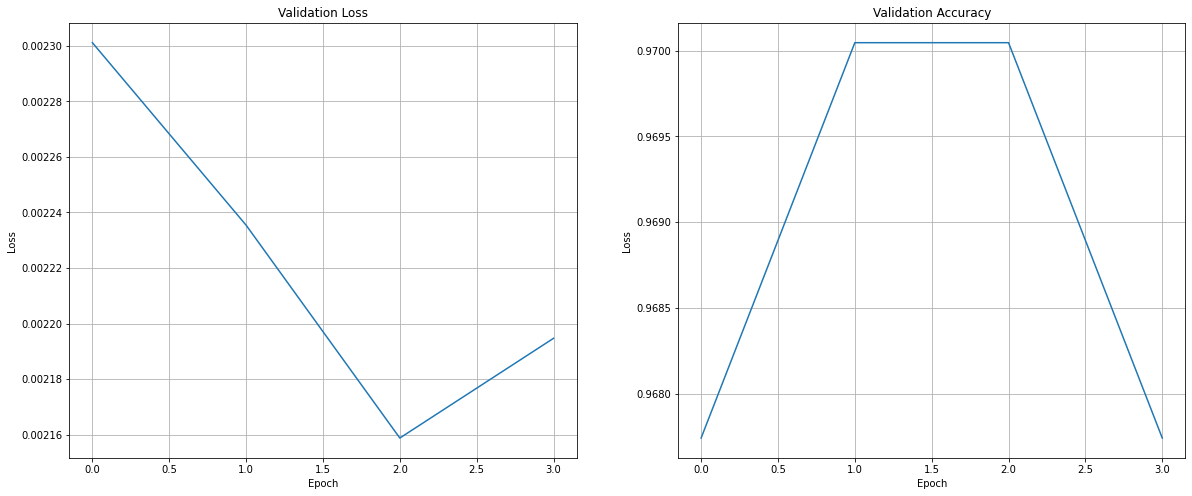

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:06:44 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0225, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 839.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1264, Validation Accuracy: 96.6590 %
Epoch 3, Train Loss: 0.0161, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 837.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1207, Validation Accuracy: 96.4286 %
Epoch 5, Train Loss: 0.0188, Train Accuracy: 99.9360 %
	 --------------------------------------

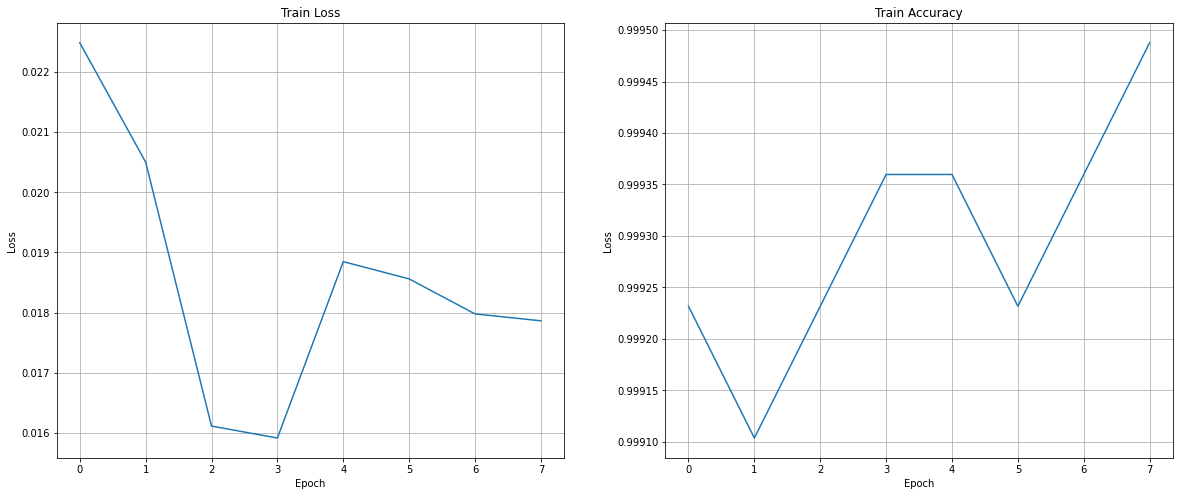

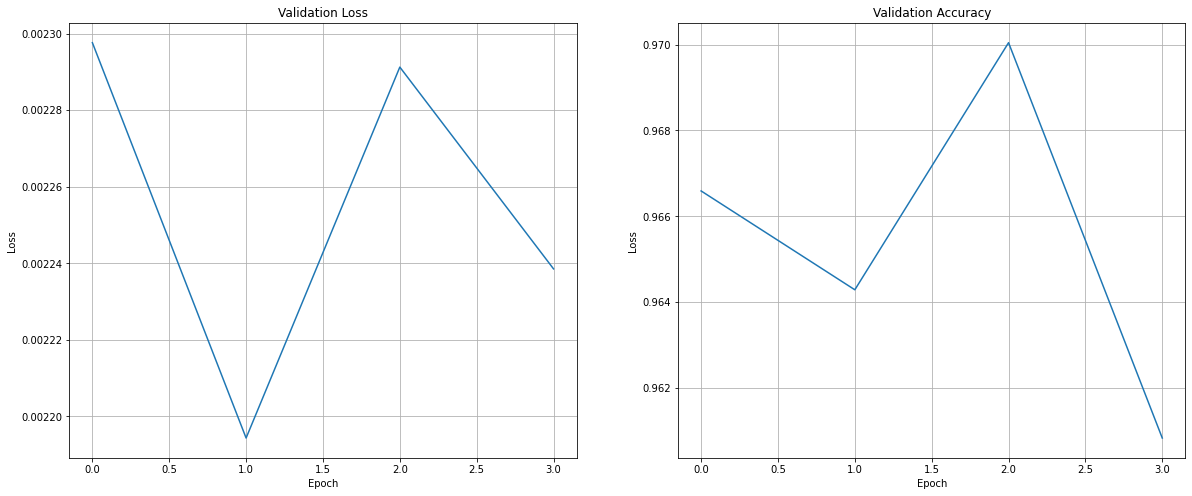

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:13:25 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0165, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 841.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1311, Validation Accuracy: 96.8894 %
Epoch 3, Train Loss: 0.0166, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 839.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1231, Validation Accuracy: 96.6590 %
Epoch 5, Train Loss: 0.0140, Train Accuracy: 99.9360 %
	 --------------------------------------

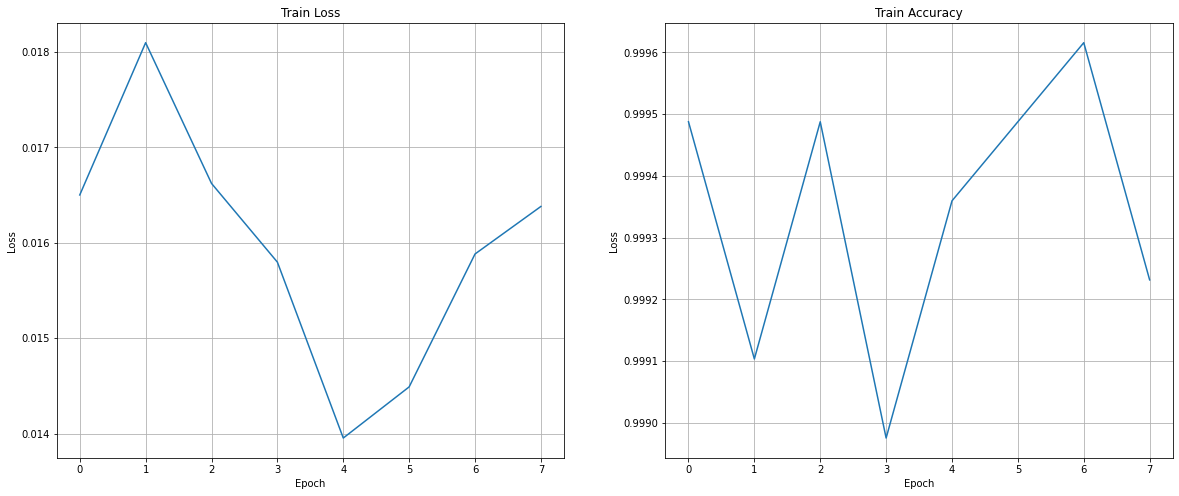

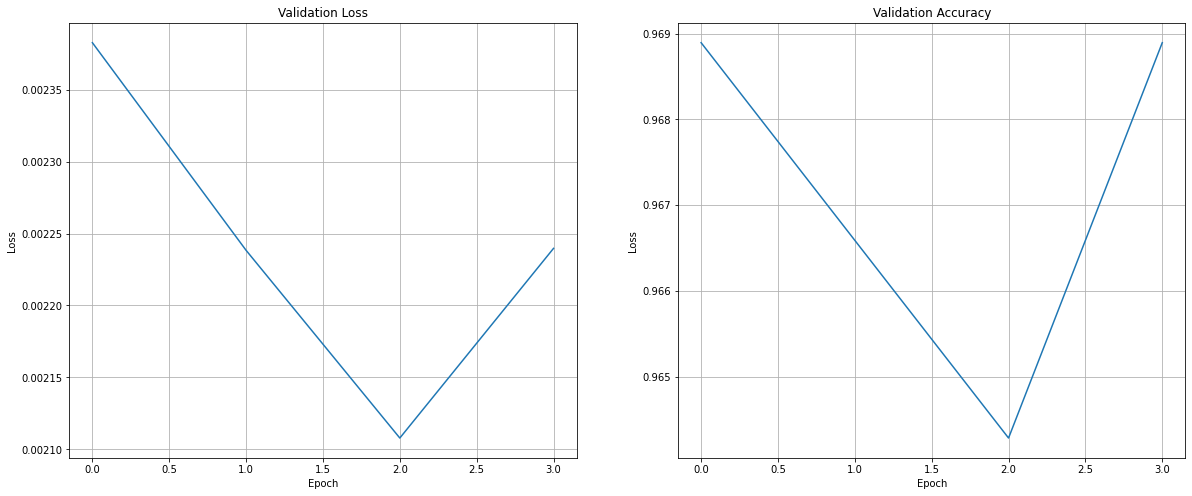

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:20:05 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0165, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1282, Validation Accuracy: 96.7742 %
Epoch 3, Train Loss: 0.0153, Train Accuracy: 99.8976 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 843.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1177, Validation Accuracy: 97.1198 %
Epoch 5, Train Loss: 0.0158, Train Accuracy: 99.9488 %
	 --------------------------------------

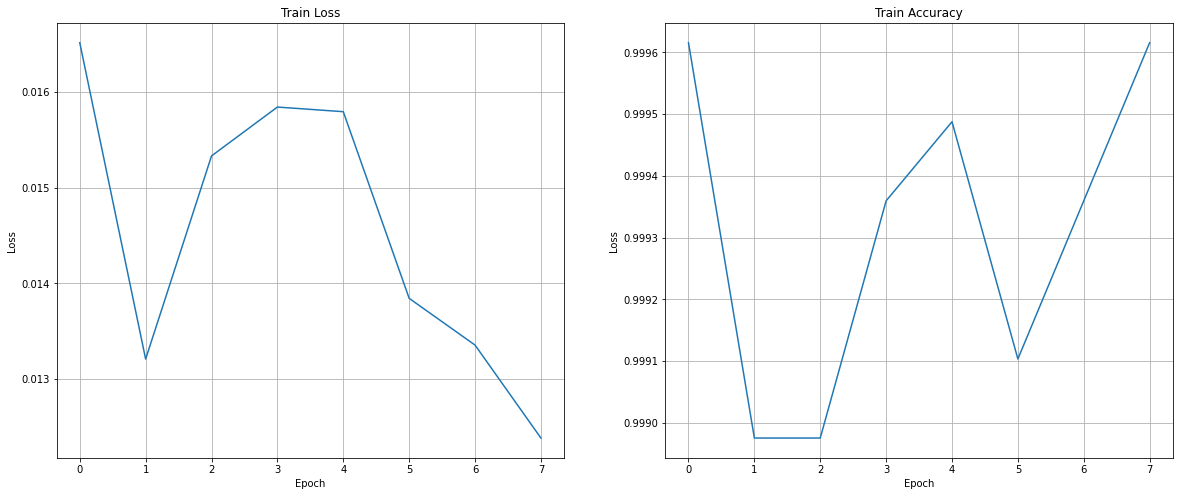

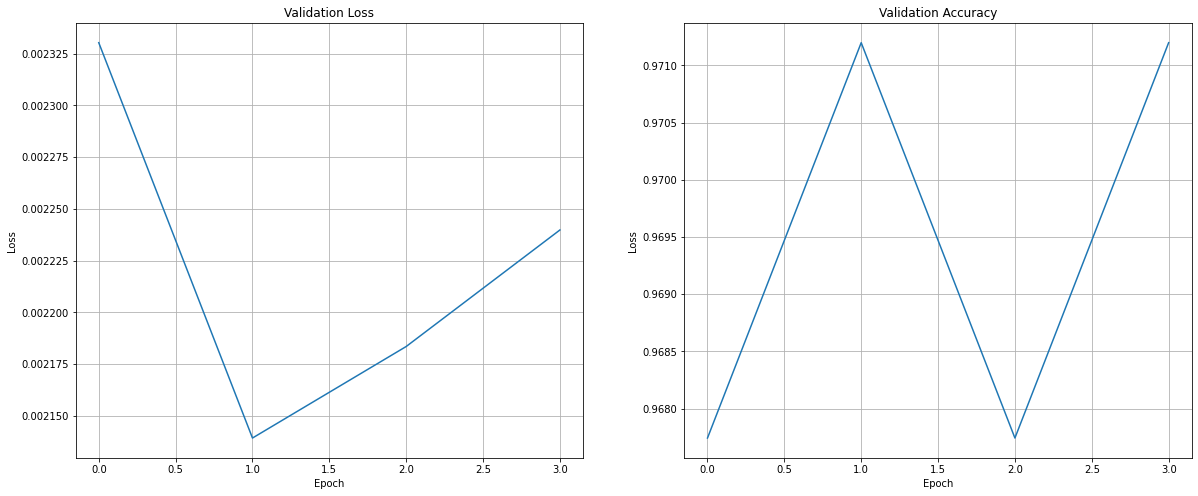

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:26:44 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0112, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 843.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1193, Validation Accuracy: 97.1198 %
Epoch 3, Train Loss: 0.0166, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 844.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1239, Validation Accuracy: 97.2350 %
Epoch 5, Train Loss: 0.0106, Train Accuracy: 99.9104 %
	 --------------------------------------

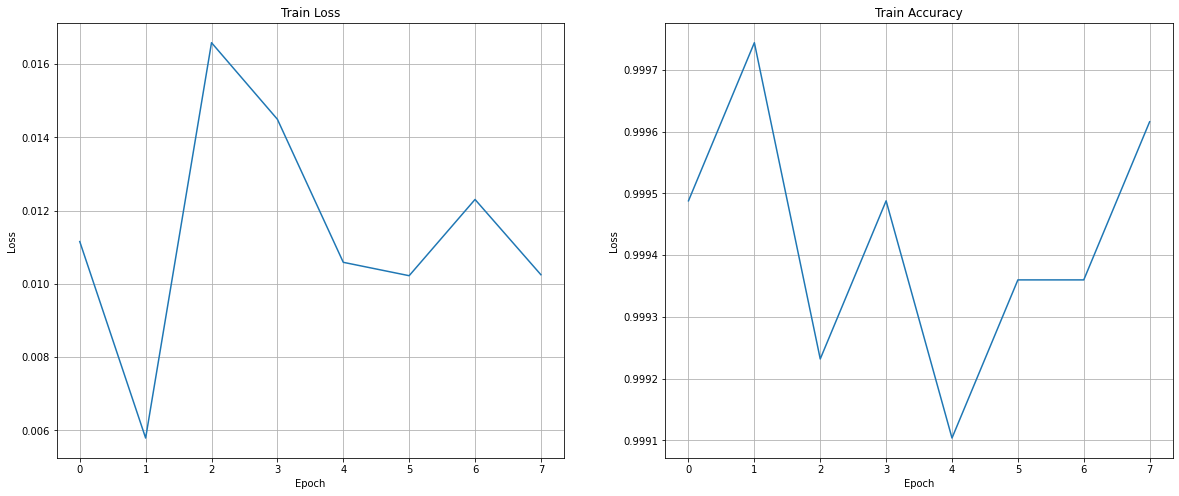

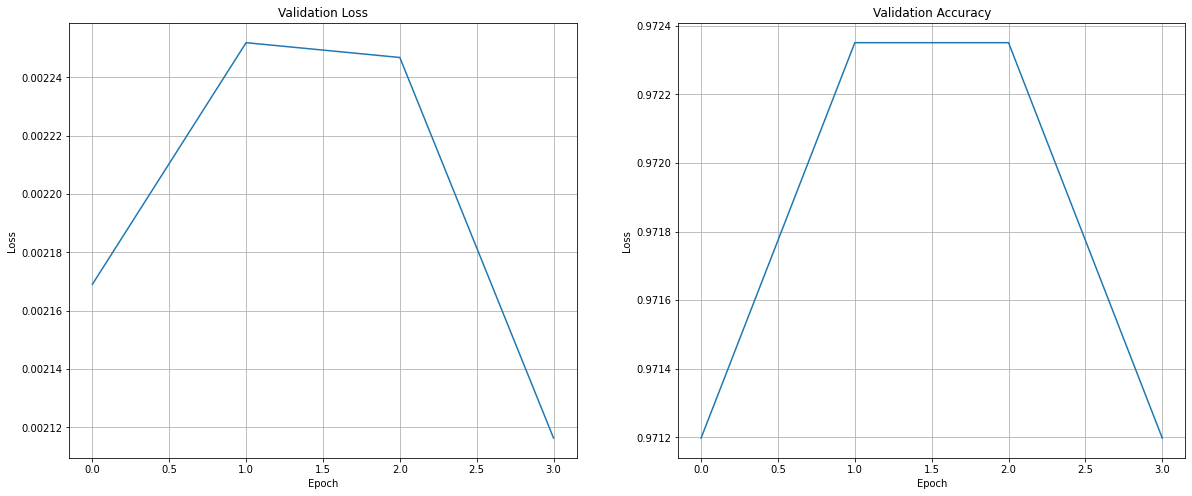

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:33:27 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0159, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1311, Validation Accuracy: 96.7742 %
Epoch 3, Train Loss: 0.0092, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 842.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1217, Validation Accuracy: 97.0046 %
Epoch 5, Train Loss: 0.0157, Train Accuracy: 99.8976 %
	 --------------------------------------

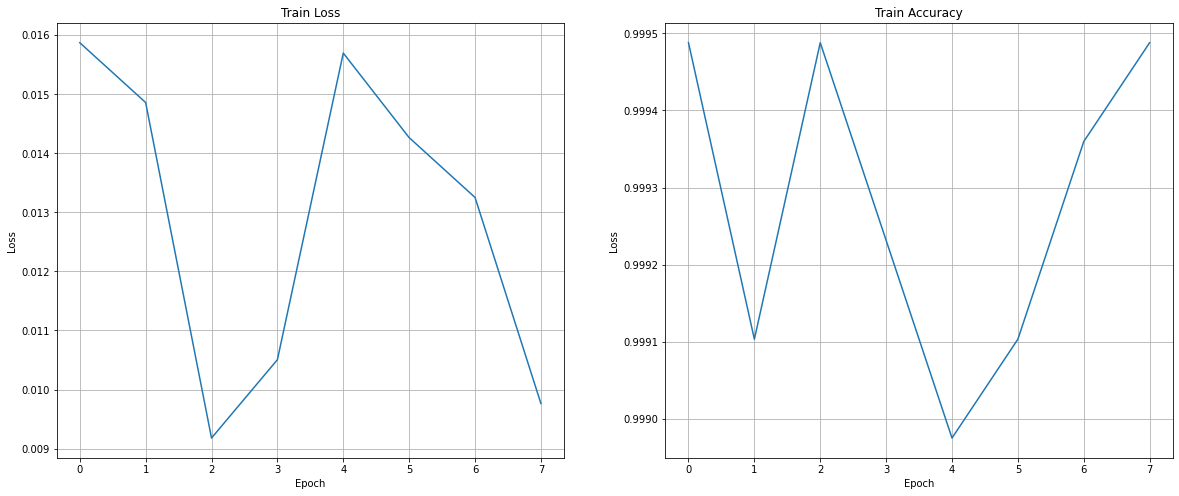

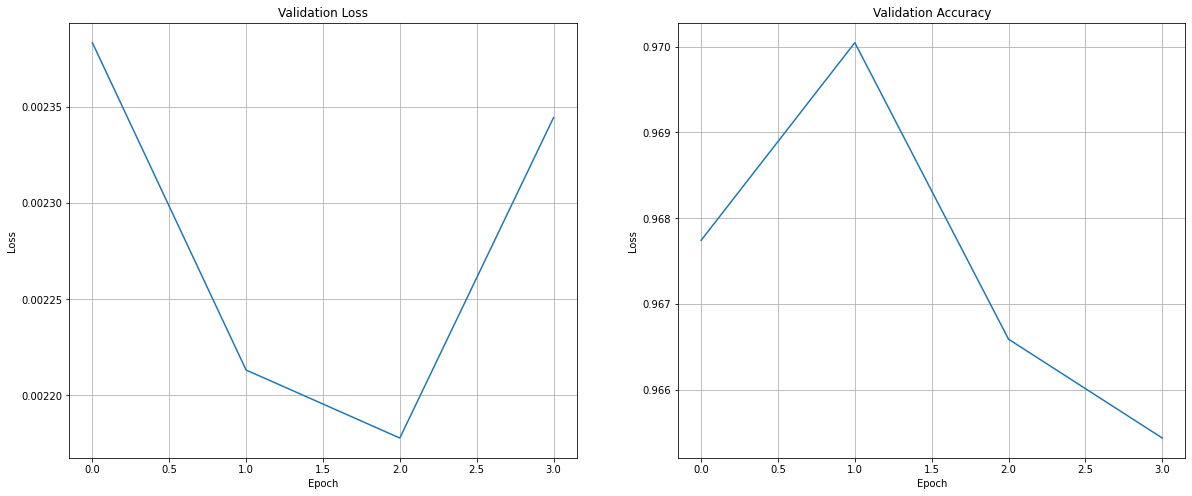

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:40:09 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0147, Train Accuracy: 99.9360 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 834.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1306, Validation Accuracy: 96.0829 %
Epoch 3, Train Loss: 0.0138, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 837.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1223, Validation Accuracy: 96.4286 %
Epoch 5, Train Loss: 0.0133, Train Accuracy: 99.9488 %
	 --------------------------------------

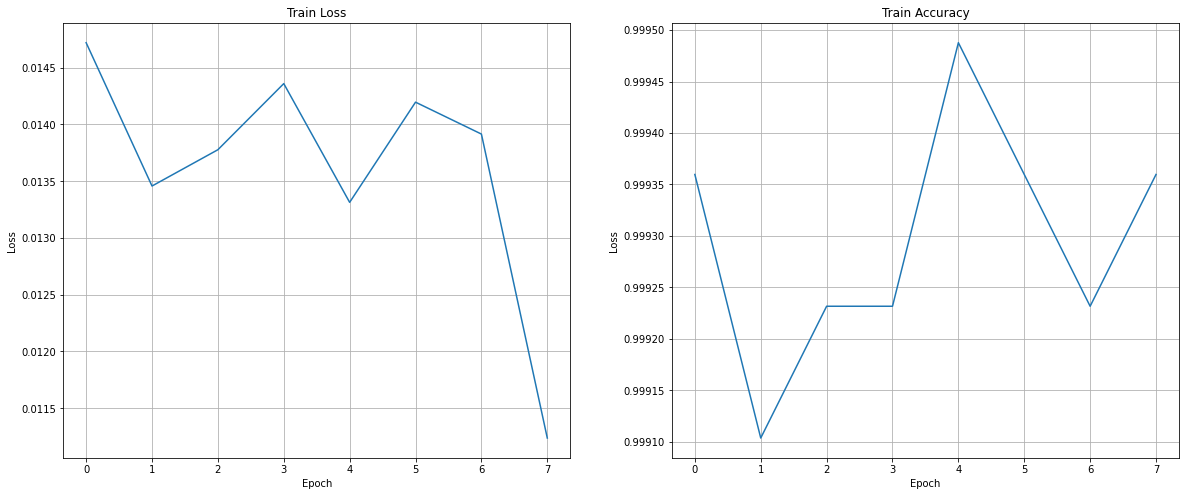

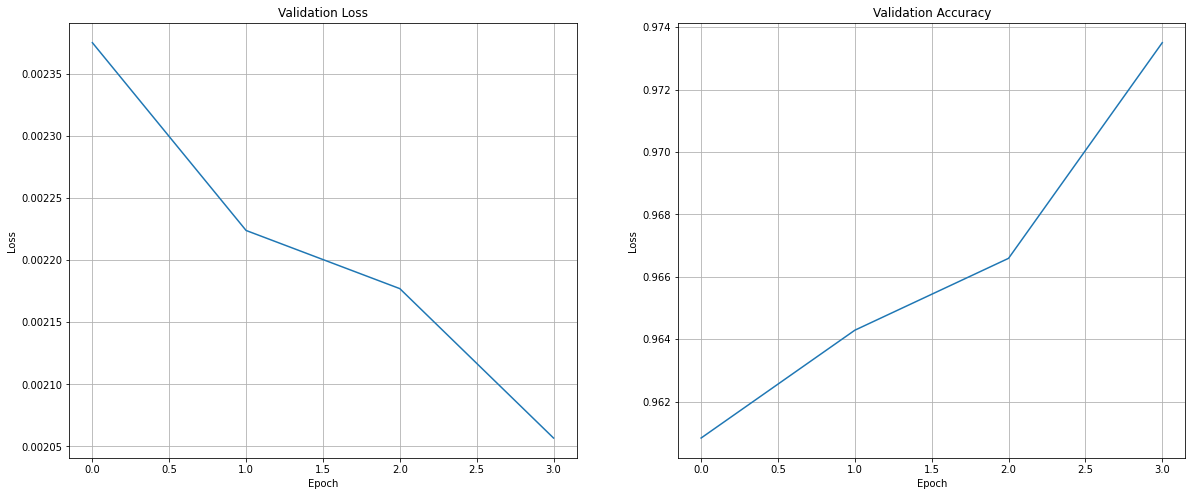

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:46:51 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0103, Train Accuracy: 99.9360 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 842.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1376, Validation Accuracy: 97.0046 %
Epoch 3, Train Loss: 0.0111, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1273, Validation Accuracy: 96.7742 %
Epoch 5, Train Loss: 0.0119, Train Accuracy: 99.9232 %
	 --------------------------------------

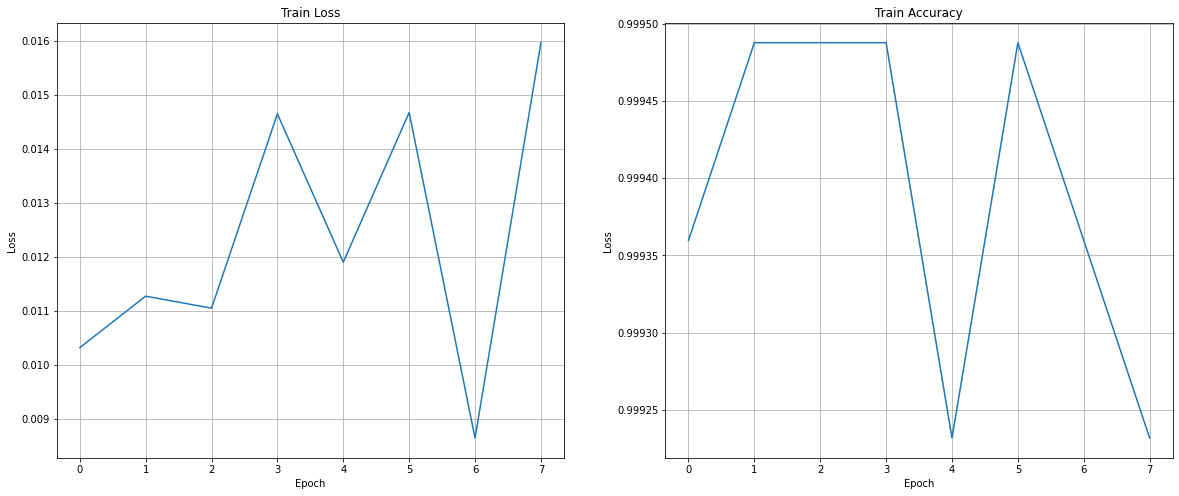

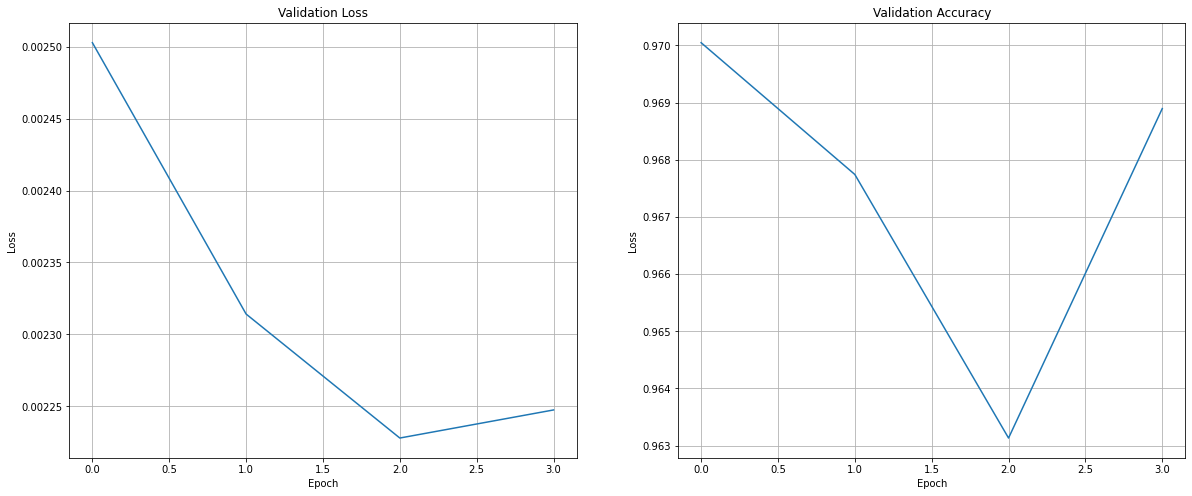

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 0:53:28 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0132, Train Accuracy: 99.9360 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1207, Validation Accuracy: 96.7742 %
Epoch 3, Train Loss: 0.0104, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([94, 88, 20, 12], device='cuda:0')
	Result : tensor([94, 88, 20, 12], device='cuda:0')
	TOTAL (correct/total): 838.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1250, Validation Accuracy: 96.5438 %
Epoch 5, Train Loss: 0.0135, Train Accuracy: 99.9488 %
	 --------------------------------------

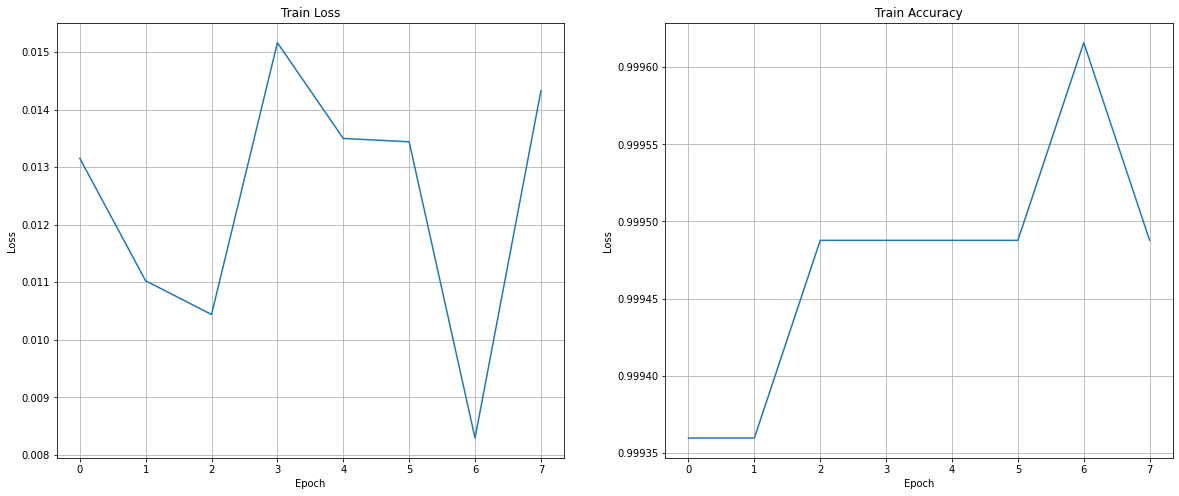

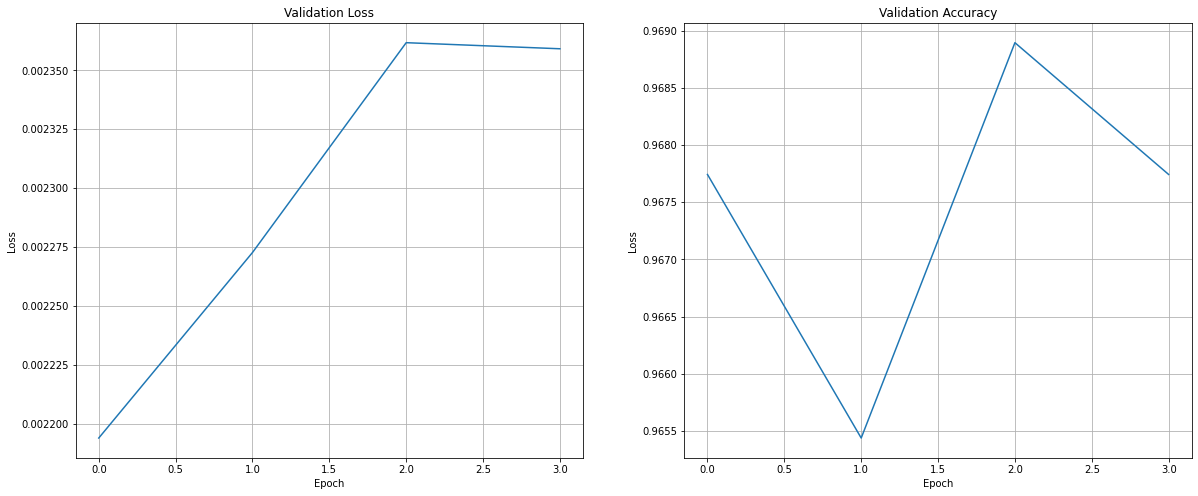

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:00:07 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La moyenne des accuracy: 386.7512 %


In [7]:
model_resnet18 = adapt_pretrained_model("resnet18")
loss_fn = nn.CrossEntropyLoss()
optimiseur_resnet18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

mean_resnet18 = boucle_de_validation_croisee_pour_k_iteration(model_resnet18, train_dataloader, test_dataloader, loss_fn, optimiseur_resnet18, epochs, typeTrain="resnet18")

## Pour le modèle alexnet avec K = 10

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.1285, Train Accuracy: 72.5829 %
	 ----------------------------------------
	Predicted : tensor([78,  5, 90, 19], device='cuda:0')
	Result : tensor([78,  5, 90, 19], device='cuda:0')
	TOTAL (correct/total): 746.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4684, Validation Accuracy: 85.9447 %
Epoch 3, Train Loss: 0.1812, Train Accuracy: 94.5063 %
	 ----------------------------------------
	Predicted : tensor([ 0, 79, 58, 86], device='cuda:0')
	Result : tensor([ 0, 79, 36, 26], device='cuda:0')
	TOTAL (correct/total): 766.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4409, Validation Accuracy: 88.2488 %
Epoch 5, Train Loss: 0.0847, Train Accuracy: 97.4260 %
	 --------------------------------------

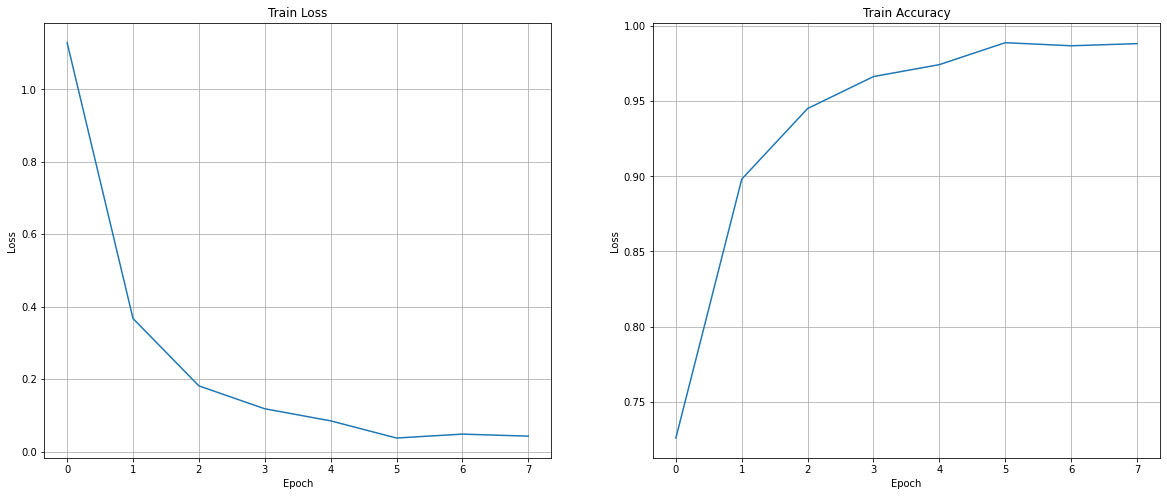

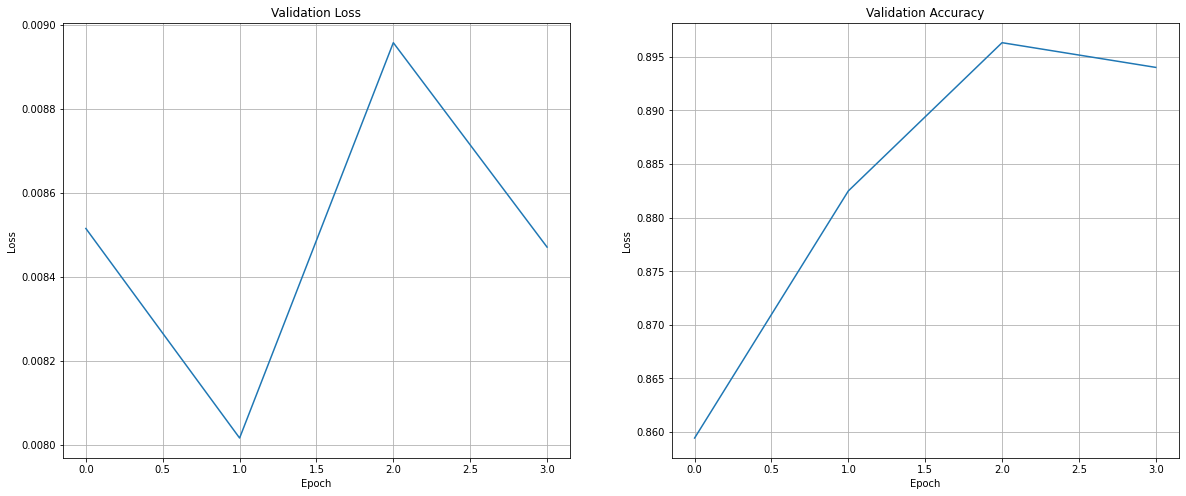

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:05:40 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0199, Train Accuracy: 99.4237 %
	 ----------------------------------------
	Predicted : tensor([12, 35, 39, 93], device='cuda:0')
	Result : tensor([12, 35, 39, 84], device='cuda:0')
	TOTAL (correct/total): 770.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4814, Validation Accuracy: 88.7097 %
Epoch 3, Train Loss: 0.0151, Train Accuracy: 99.6030 %
	 ----------------------------------------
	Predicted : tensor([27,  3, 33, 12], device='cuda:0')
	Result : tensor([27,  3, 33, 12], device='cuda:0')
	TOTAL (correct/total): 776.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4160, Validation Accuracy: 89.4009 %
Epoch 5, Train Loss: 0.0068, Train Accuracy: 99.8847 %
	 --------------------------------------

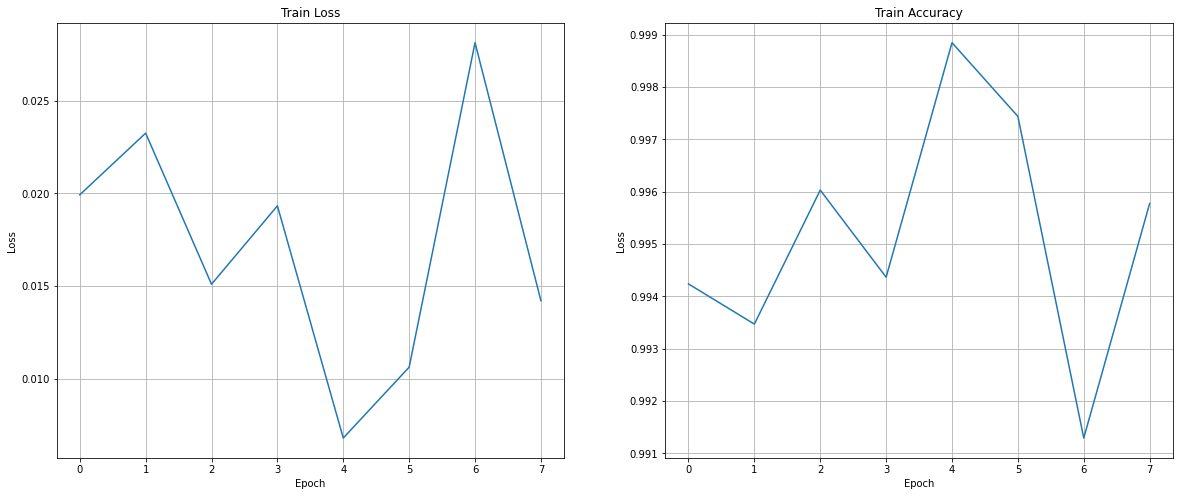

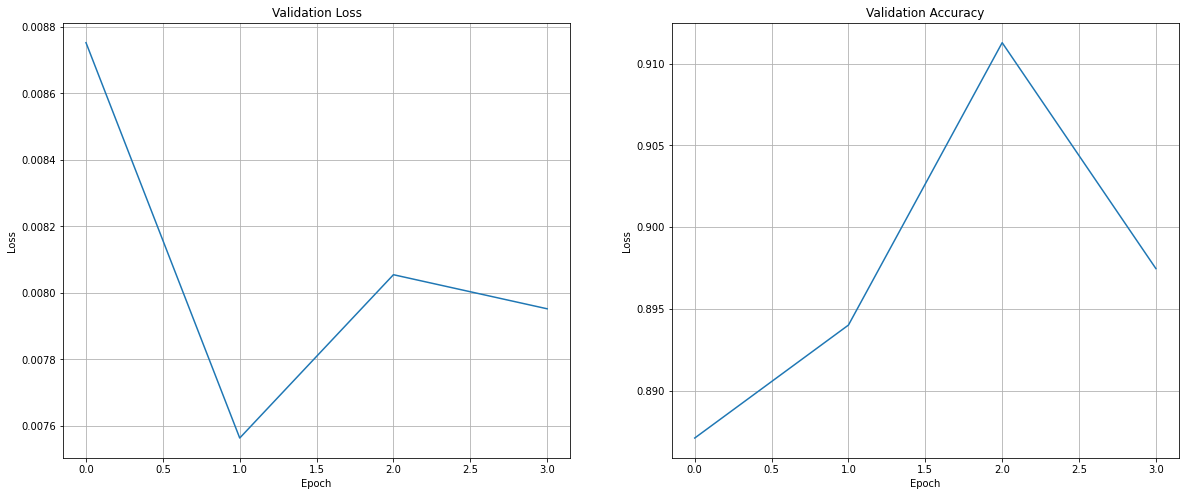

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:11:05 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0044, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([22, 97,  1, 62], device='cuda:0')
	Result : tensor([22, 97,  1, 62], device='cuda:0')
	TOTAL (correct/total): 795.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4219, Validation Accuracy: 91.5899 %
Epoch 3, Train Loss: 0.0107, Train Accuracy: 99.6158 %
	 ----------------------------------------
	Predicted : tensor([94, 57, 96,  3], device='cuda:0')
	Result : tensor([17, 57, 96,  3], device='cuda:0')
	TOTAL (correct/total): 791.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4355, Validation Accuracy: 91.1290 %
Epoch 5, Train Loss: 0.0032, Train Accuracy: 99.9232 %
	 --------------------------------------

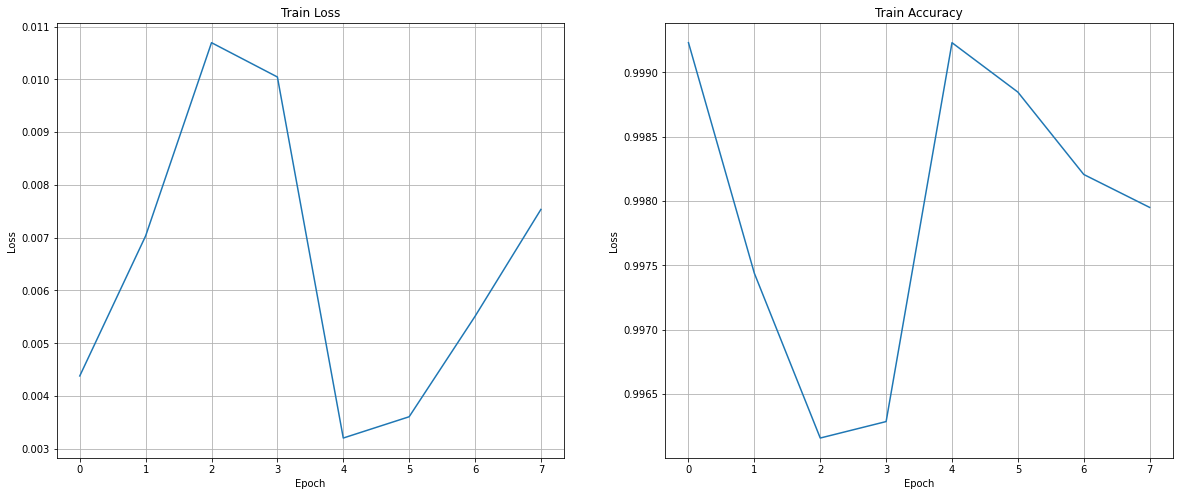

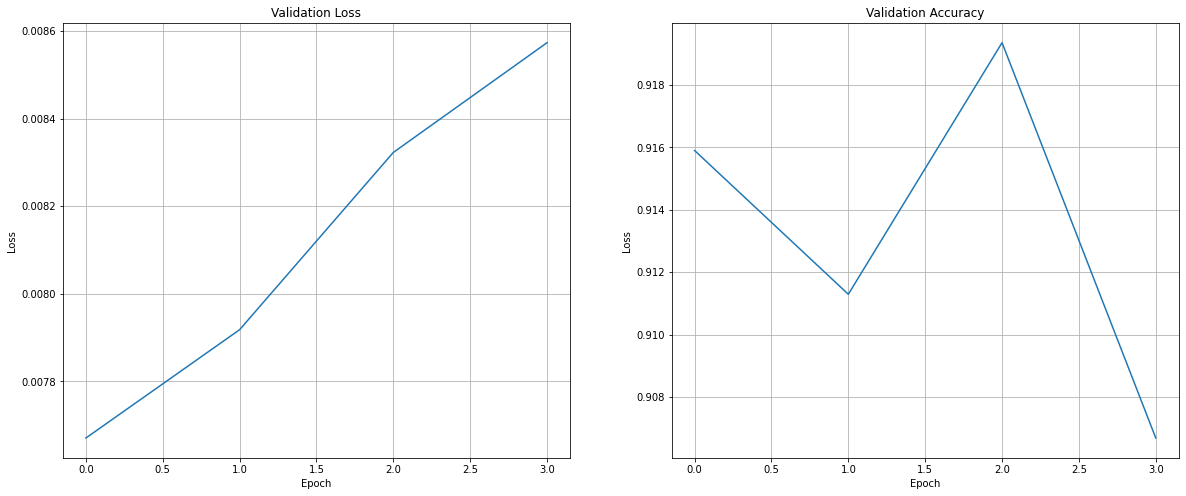

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:16:28 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0039, Train Accuracy: 99.8976 %
	 ----------------------------------------
	Predicted : tensor([92, 54, 22, 92], device='cuda:0')
	Result : tensor([92, 54,  6, 92], device='cuda:0')
	TOTAL (correct/total): 794.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4437, Validation Accuracy: 91.4747 %
Epoch 3, Train Loss: 0.0027, Train Accuracy: 99.9360 %
	 ----------------------------------------
	Predicted : tensor([33, 84, 43, 23], device='cuda:0')
	Result : tensor([33, 84, 43, 23], device='cuda:0')
	TOTAL (correct/total): 800.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4333, Validation Accuracy: 92.1659 %
Epoch 5, Train Loss: 0.0021, Train Accuracy: 99.9360 %
	 --------------------------------------

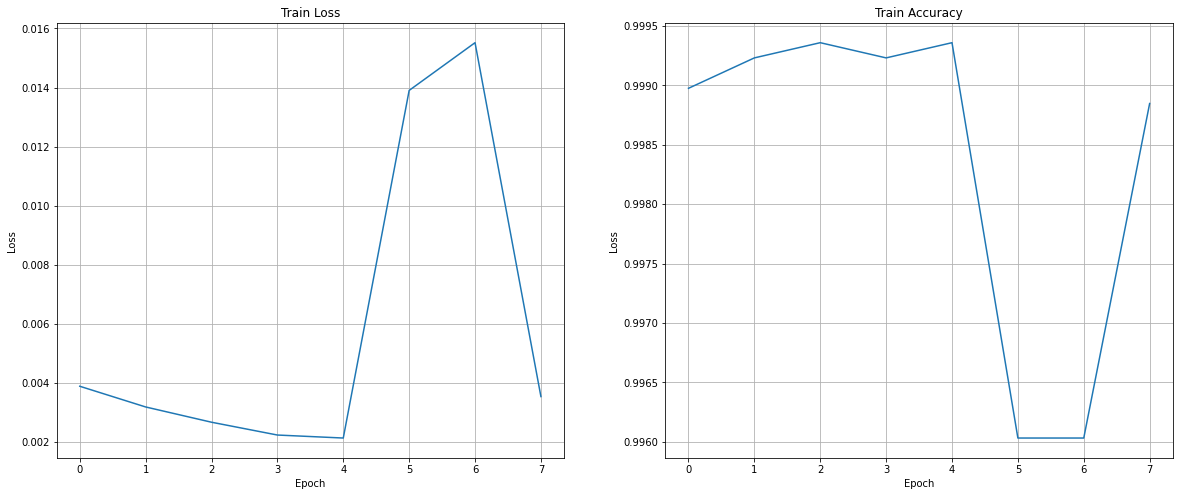

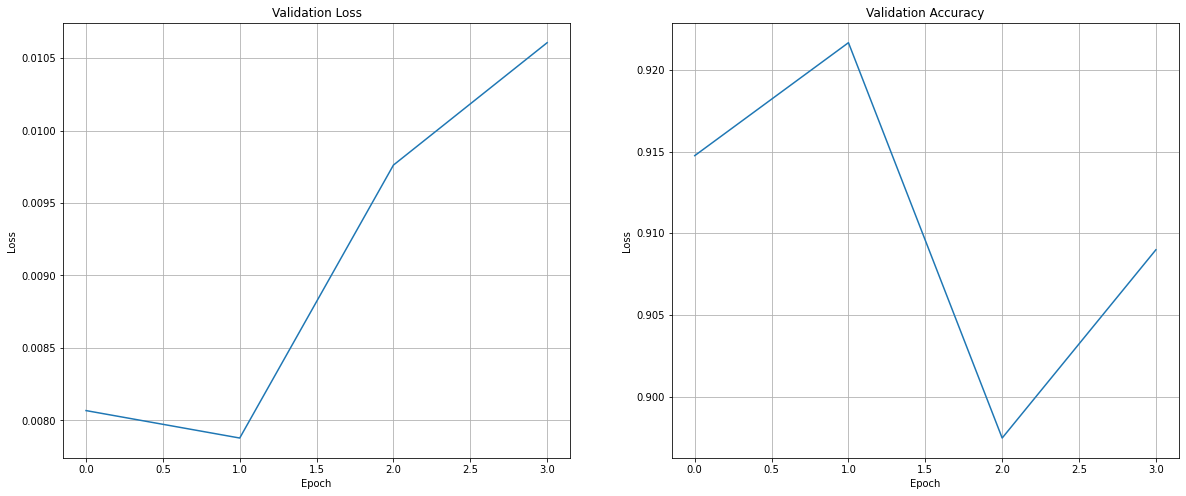

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:21:49 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0091, Train Accuracy: 99.7055 %
	 ----------------------------------------
	Predicted : tensor([1, 3, 0, 3], device='cuda:0')
	Result : tensor([1, 3, 0, 3], device='cuda:0')
	TOTAL (correct/total): 789.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4685, Validation Accuracy: 90.8986 %
Epoch 3, Train Loss: 0.0057, Train Accuracy: 99.8463 %
	 ----------------------------------------
	Predicted : tensor([ 5, 17, 75, 79], device='cuda:0')
	Result : tensor([ 5, 17, 75, 79], device='cuda:0')
	TOTAL (correct/total): 798.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4126, Validation Accuracy: 91.9355 %
Epoch 5, Train Loss: 0.0032, Train Accuracy: 99.8463 %
	 ----------------------------------------
	Pred

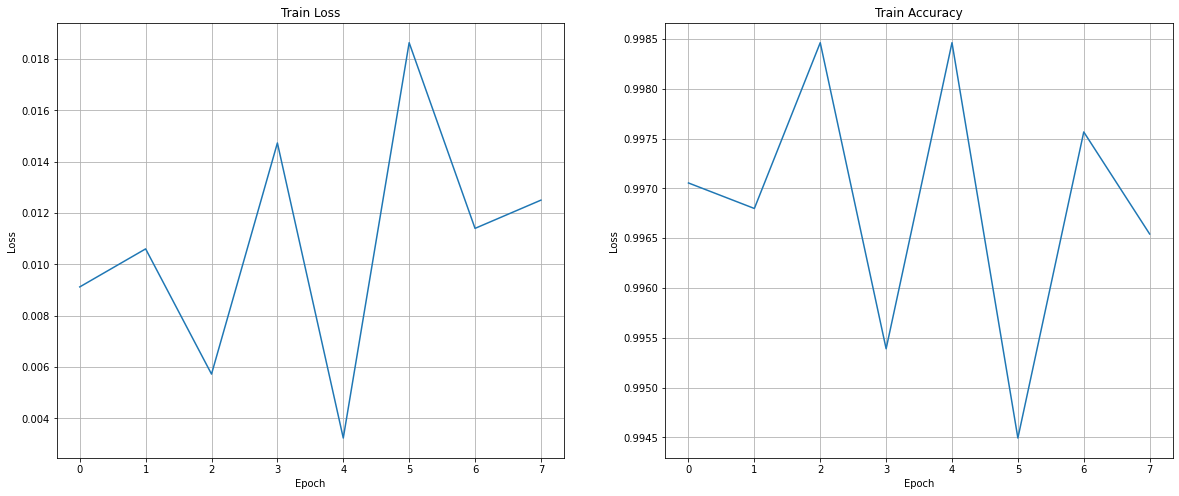

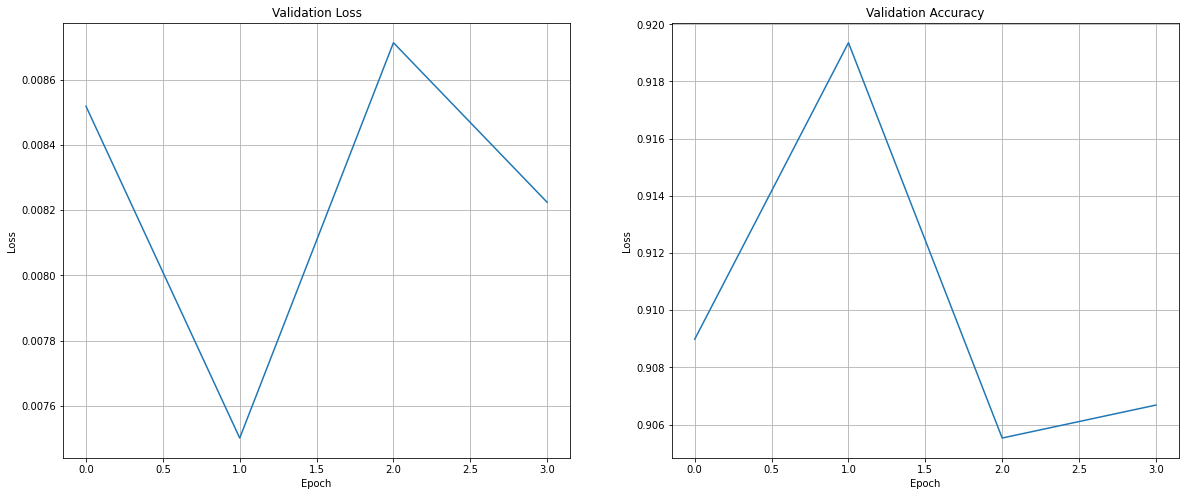

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:27:20 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0045, Train Accuracy: 99.8591 %
	 ----------------------------------------
	Predicted : tensor([47,  5, 92, 90], device='cuda:0')
	Result : tensor([47,  5, 92, 90], device='cuda:0')
	TOTAL (correct/total): 792.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4545, Validation Accuracy: 91.2442 %
Epoch 3, Train Loss: 0.0023, Train Accuracy: 99.9360 %
	 ----------------------------------------
	Predicted : tensor([69, 55,  3, 78], device='cuda:0')
	Result : tensor([69, 79,  3, 78], device='cuda:0')
	TOTAL (correct/total): 792.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4680, Validation Accuracy: 91.2442 %
Epoch 5, Train Loss: 0.0018, Train Accuracy: 99.9104 %
	 --------------------------------------

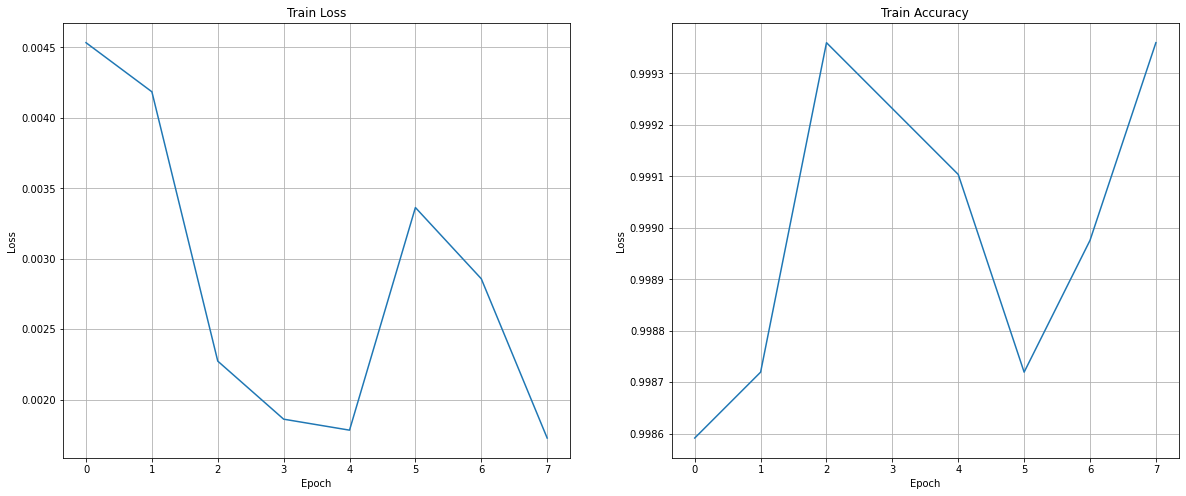

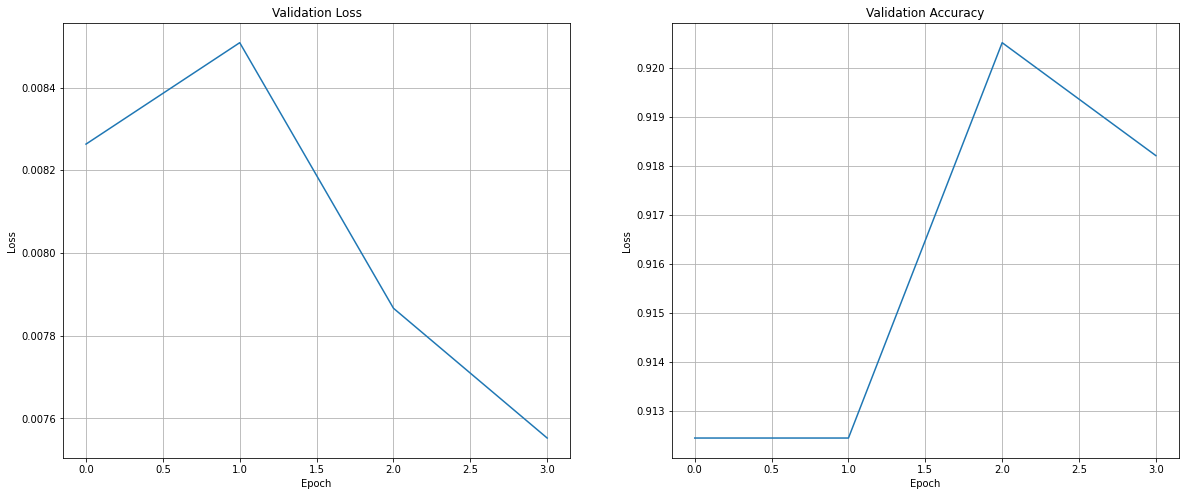

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:32:46 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0013, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([49, 64,  0, 94], device='cuda:0')
	Result : tensor([49, 64,  0, 94], device='cuda:0')
	TOTAL (correct/total): 794.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4179, Validation Accuracy: 91.4747 %
Epoch 3, Train Loss: 0.0041, Train Accuracy: 99.8976 %
	 ----------------------------------------
	Predicted : tensor([62, 53, 38,  1], device='cuda:0')
	Result : tensor([62, 53, 38,  1], device='cuda:0')
	TOTAL (correct/total): 792.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4070, Validation Accuracy: 91.2442 %
Epoch 5, Train Loss: 0.0027, Train Accuracy: 99.9104 %
	 --------------------------------------

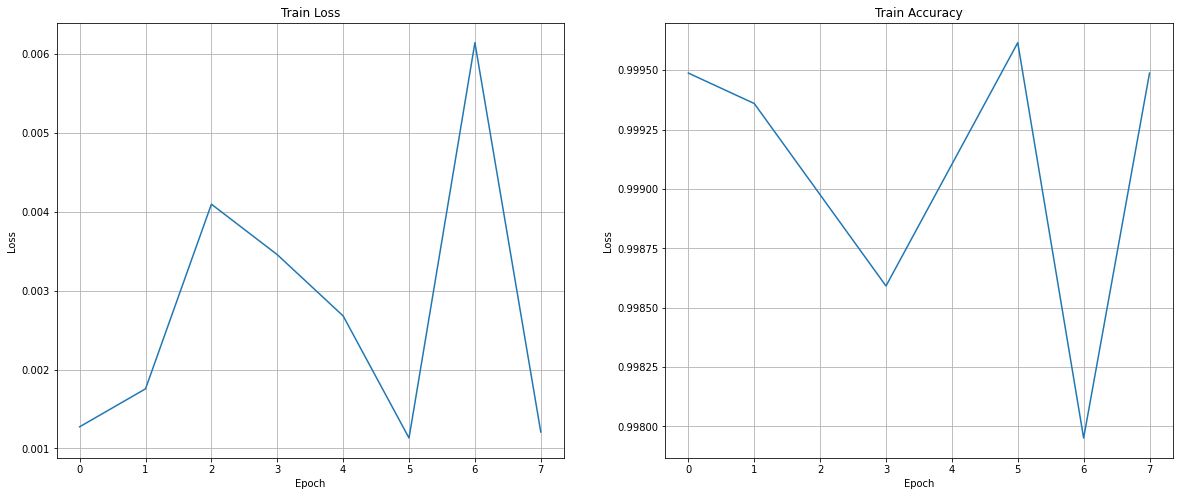

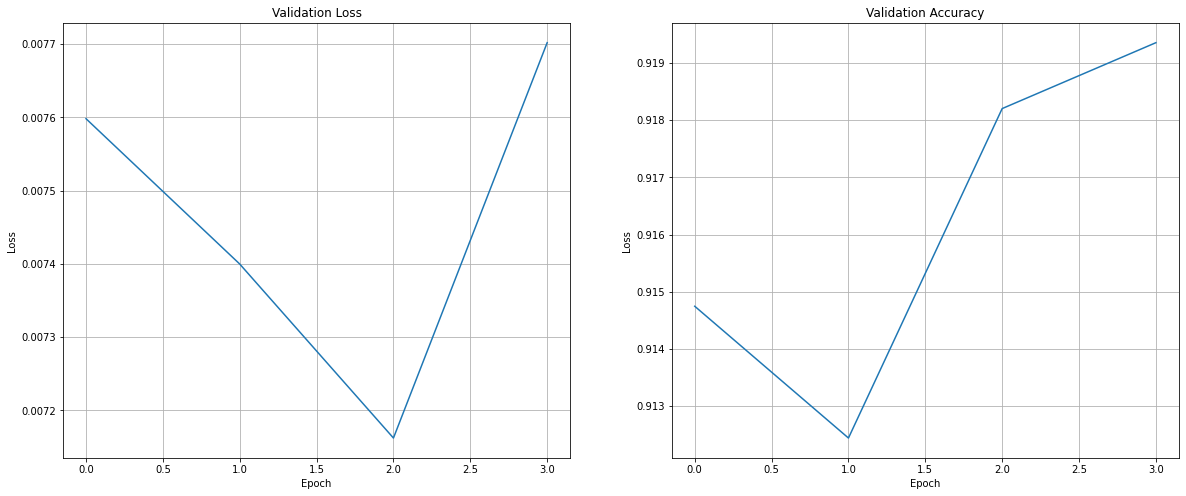

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:38:13 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0011, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([ 99, 100,  21,   1], device='cuda:0')
	Result : tensor([99, 17, 21,  1], device='cuda:0')
	TOTAL (correct/total): 800.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4580, Validation Accuracy: 92.1659 %
Epoch 3, Train Loss: 0.0082, Train Accuracy: 99.7695 %
	 ----------------------------------------
	Predicted : tensor([39, 94,  1,  3], device='cuda:0')
	Result : tensor([39, 94,  0,  3], device='cuda:0')
	TOTAL (correct/total): 792.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4544, Validation Accuracy: 91.2442 %
Epoch 5, Train Loss: 0.0022, Train Accuracy: 99.9360 %
	 ----------------------------------

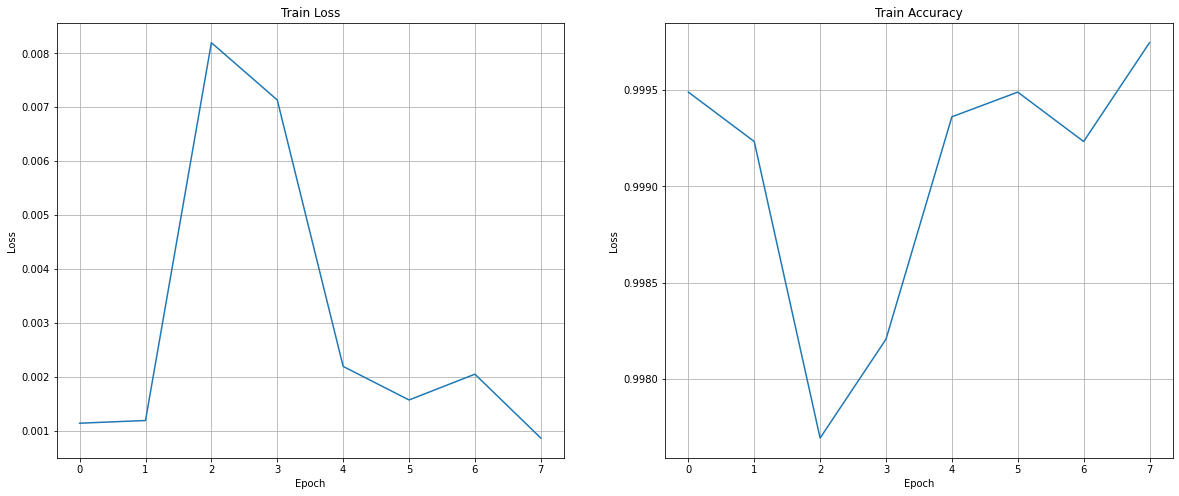

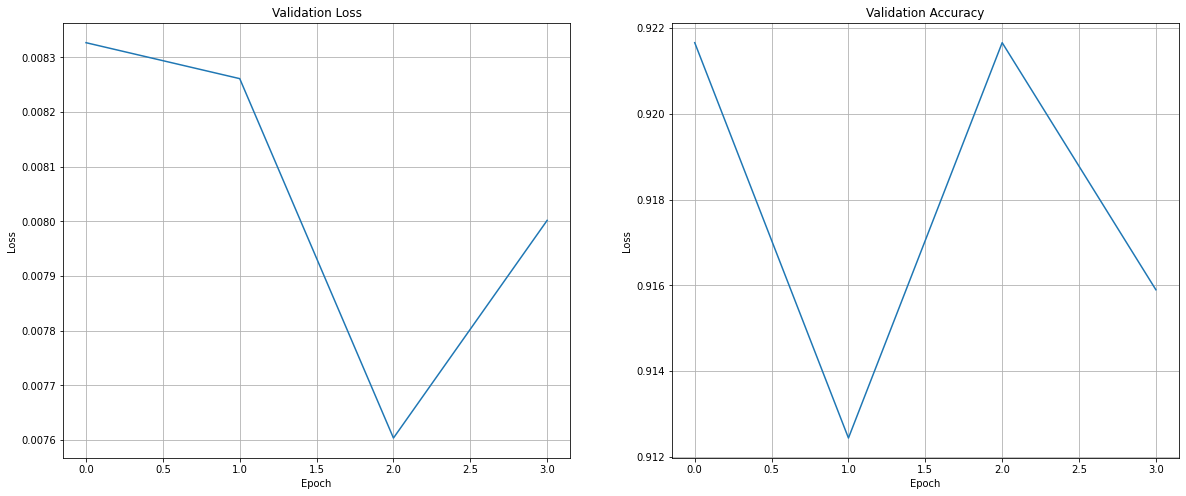

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:43:41 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0014, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([47,  3, 90, 22], device='cuda:0')
	Result : tensor([47,  3, 90, 22], device='cuda:0')
	TOTAL (correct/total): 795.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.4399, Validation Accuracy: 91.5899 %
Epoch 3, Train Loss: 0.0007, Train Accuracy: 99.9744 %
	 ----------------------------------------
	Predicted : tensor([ 1, 21, 47,  0], device='cuda:0')
	Result : tensor([ 1, 21, 47,  0], device='cuda:0')
	TOTAL (correct/total): 796.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4790, Validation Accuracy: 91.7051 %
Epoch 5, Train Loss: 0.0056, Train Accuracy: 99.7951 %
	 --------------------------------------

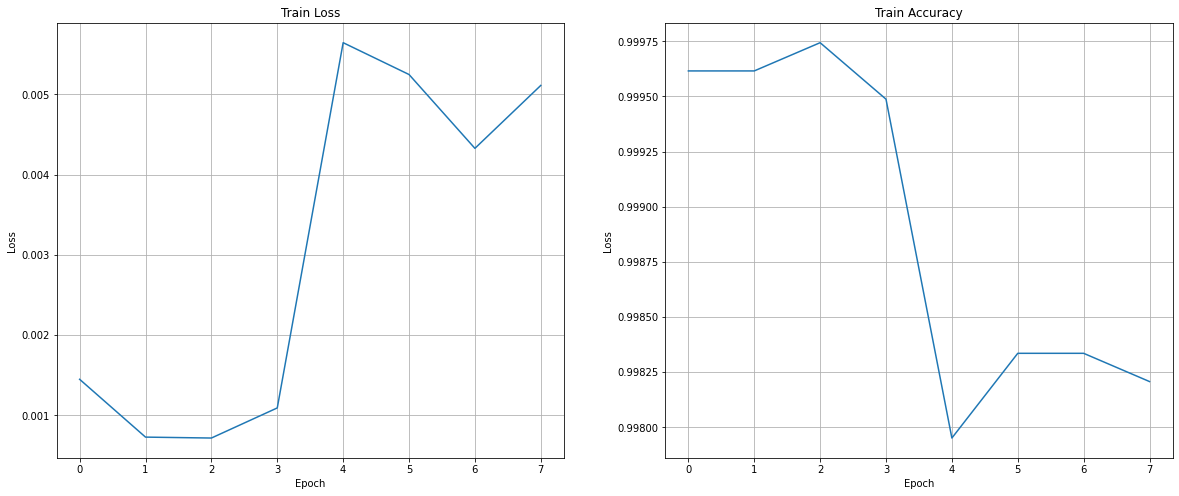

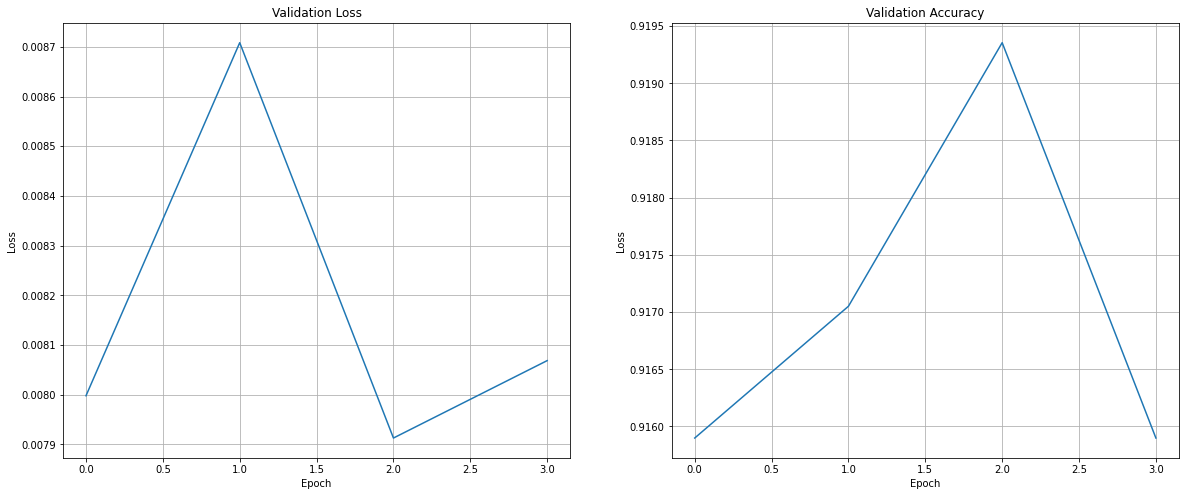

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:49:08 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0021, Train Accuracy: 99.9104 %
	 ----------------------------------------
	Predicted : tensor([ 9, 76, 34, 73], device='cuda:0')
	Result : tensor([ 9, 76, 34, 68], device='cuda:0')
	TOTAL (correct/total): 789.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.5069, Validation Accuracy: 90.8986 %
Epoch 3, Train Loss: 0.0019, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([92, 86, 23,  0], device='cuda:0')
	Result : tensor([92, 86, 23,  0], device='cuda:0')
	TOTAL (correct/total): 792.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.4775, Validation Accuracy: 91.2442 %
Epoch 5, Train Loss: 0.0011, Train Accuracy: 99.9488 %
	 --------------------------------------

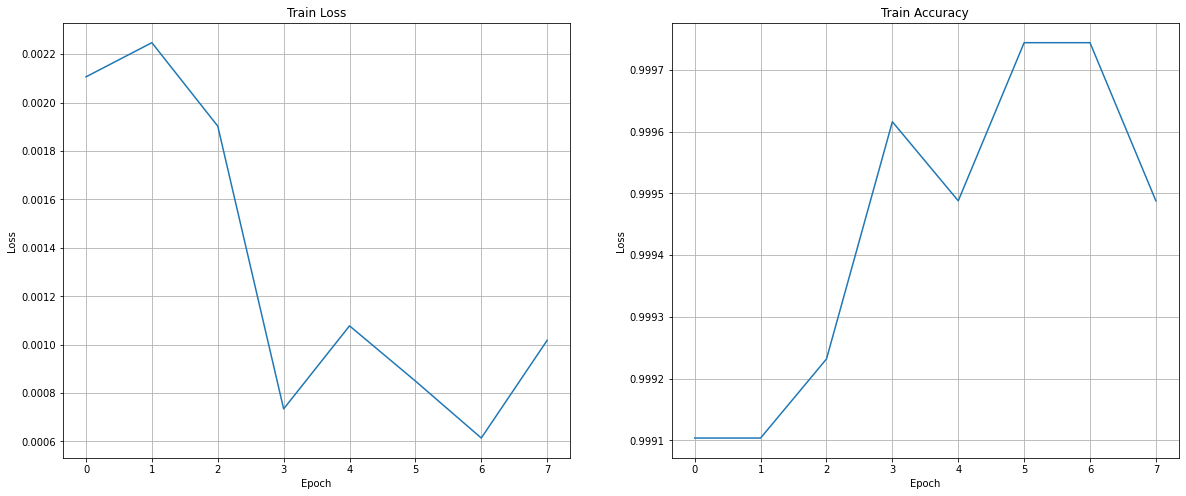

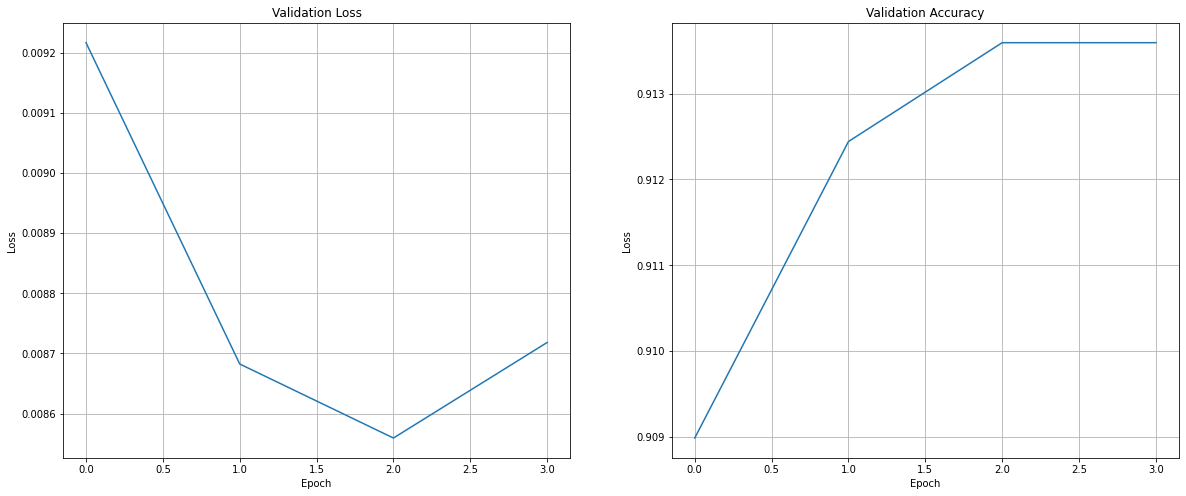

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 1:54:33 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La moyenne des accuracy: 363.7558 %


In [10]:
model_alexnet = adapt_pretrained_model("alexnet")
loss_fn = nn.CrossEntropyLoss()
optimiseur_alexnet = torch.optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

mean_alexnet = boucle_de_validation_croisee_pour_k_iteration(model_alexnet, train_dataloader, test_dataloader, loss_fn, optimiseur_alexnet, epochs, typeTrain="alexnet")

## Pour le modèle squeezenet1_0 avec K = 10

In [ ]:
model_squeezenet1_0 = adapt_pretrained_model("squeezenet1_0")
loss_fn = nn.CrossEntropyLoss()
optimiseur_squeezenet1_0 = torch.optim.SGD(model_squeezenet1_0.parameters(), lr=0.001, momentum=0.9)

mean_squeezenet1_0 = boucle_de_validation_croisee_pour_k_iteration(model_squeezenet1_0, train_dataloader, test_dataloader, loss_fn, optimiseur_squeezenet1_0, epochs, typeTrain="squeezenet1_0")

## Pour le modèle vgg16 avec K = 10

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 1.0185, Train Accuracy: 75.9380 %
	 ----------------------------------------
	Predicted : tensor([84, 46, 50,  5], device='cuda:0')
	Result : tensor([84, 46, 50,  5], device='cuda:0')
	TOTAL (correct/total): 810.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.2468, Validation Accuracy: 93.3180 %
Epoch 3, Train Loss: 0.1211, Train Accuracy: 96.4528 %
	 ----------------------------------------
	Predicted : tensor([53,  5, 12,  0], device='cuda:0')
	Result : tensor([53,  5, 12,  0], device='cuda:0')
	TOTAL (correct/total): 828.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1769, Validation Accuracy: 95.3917 %
Epoch 5, Train Loss: 0.0499, Train Accuracy: 98.4633 %
	 --------------------------------------

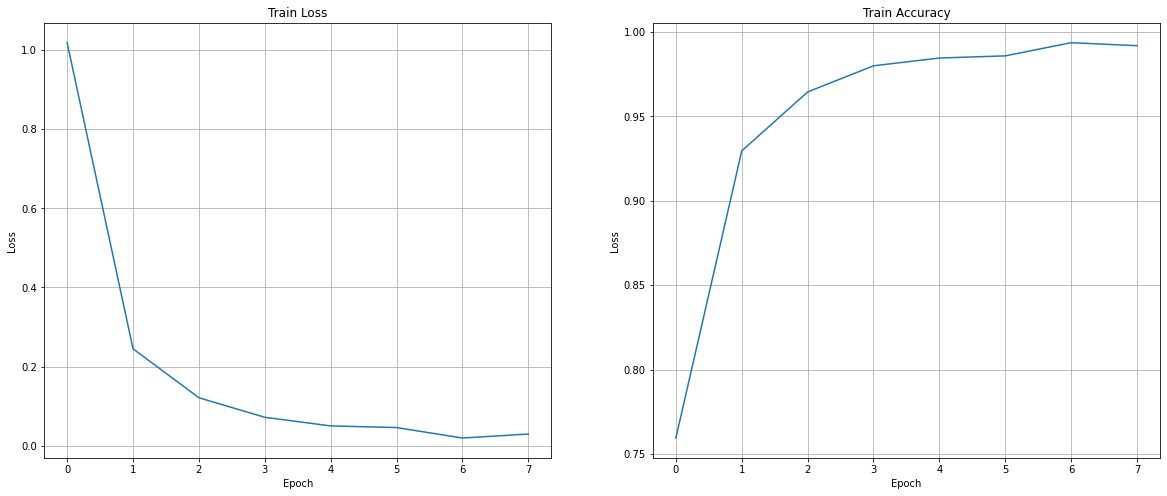

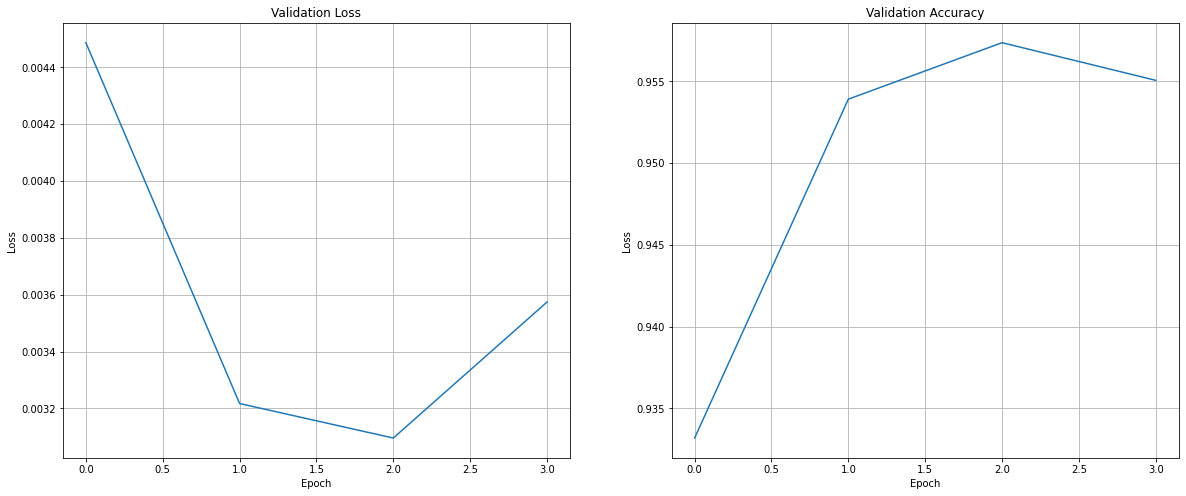

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 2:21:58 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0210, Train Accuracy: 99.2573 %
	 ----------------------------------------
	Predicted : tensor([88, 69, 70, 84], device='cuda:0')
	Result : tensor([88, 69, 70, 84], device='cuda:0')
	TOTAL (correct/total): 833.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1869, Validation Accuracy: 95.9677 %
Epoch 3, Train Loss: 0.0152, Train Accuracy: 99.6158 %
	 ----------------------------------------
	Predicted : tensor([95, 80, 98, 62], device='cuda:0')
	Result : tensor([95, 80, 98, 62], device='cuda:0')
	TOTAL (correct/total): 833.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1882, Validation Accuracy: 95.9677 %
Epoch 5, Train Loss: 0.0094, Train Accuracy: 99.7311 %
	 --------------------------------------

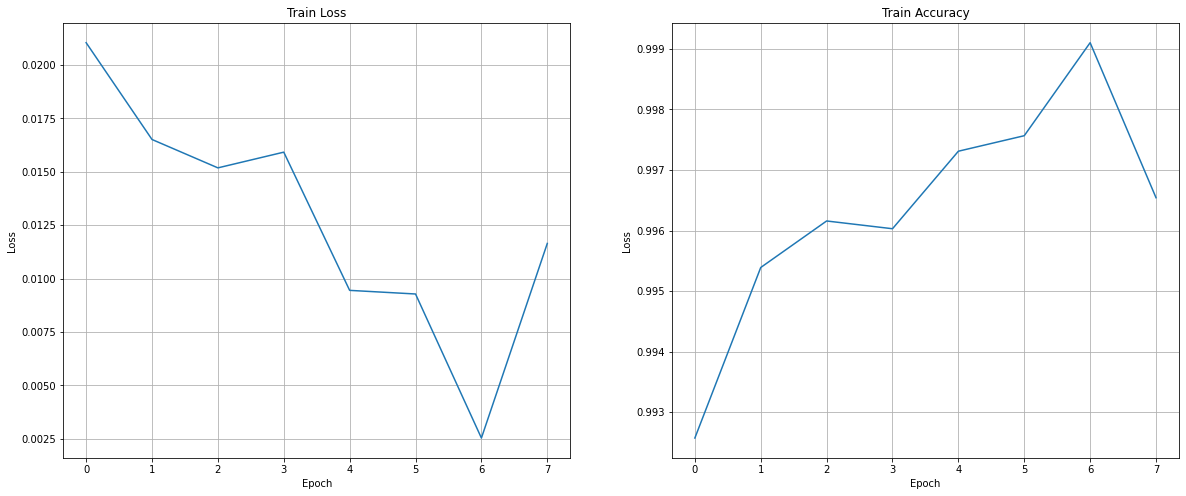

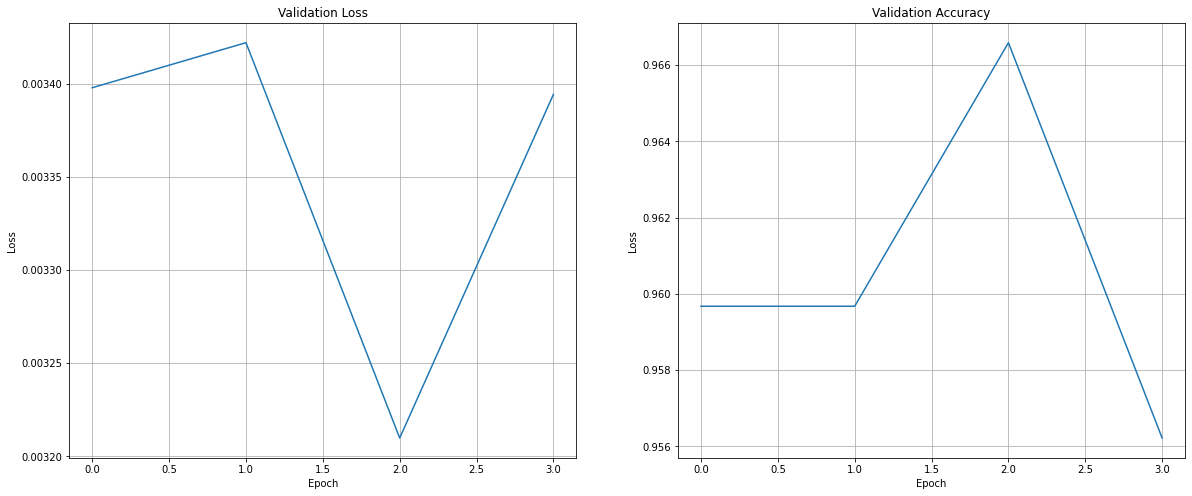

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 2:41:50 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0162, Train Accuracy: 99.6414 %
	 ----------------------------------------
	Predicted : tensor([91, 21, 36, 81], device='cuda:0')
	Result : tensor([91, 21, 36, 81], device='cuda:0')
	TOTAL (correct/total): 838.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1741, Validation Accuracy: 96.5438 %
Epoch 3, Train Loss: 0.0027, Train Accuracy: 99.9104 %
	 ----------------------------------------
	Predicted : tensor([ 8, 70, 38, 29], device='cuda:0')
	Result : tensor([ 8, 70, 38, 29], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1377, Validation Accuracy: 96.7742 %
Epoch 5, Train Loss: 0.0078, Train Accuracy: 99.7567 %
	 --------------------------------------

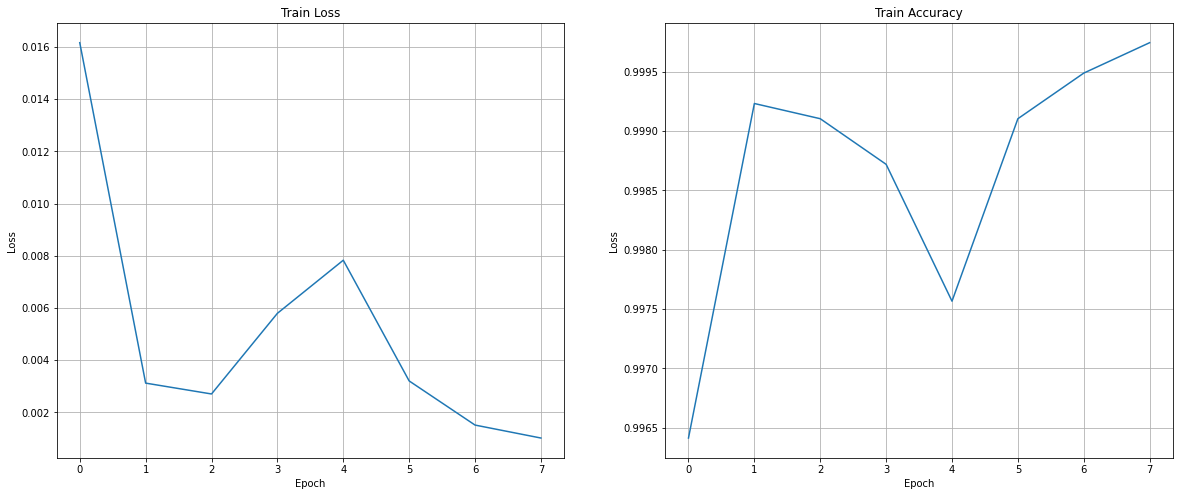

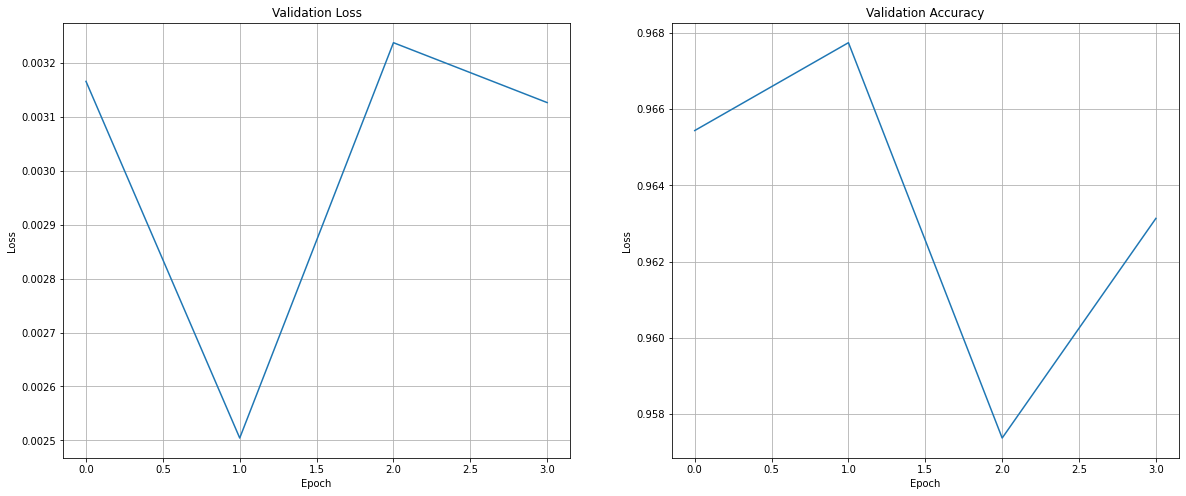

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 3:01:43 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0011, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([88, 93, 95,  5], device='cuda:0')
	Result : tensor([88, 93, 60,  5], device='cuda:0')
	TOTAL (correct/total): 839.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1890, Validation Accuracy: 96.6590 %
Epoch 3, Train Loss: 0.0009, Train Accuracy: 99.9744 %
	 ----------------------------------------
	Predicted : tensor([66,  0,  3, 90], device='cuda:0')
	Result : tensor([66,  0,  3, 90], device='cuda:0')
	TOTAL (correct/total): 837.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1998, Validation Accuracy: 96.4286 %
Epoch 5, Train Loss: 0.0024, Train Accuracy: 99.9232 %
	 --------------------------------------

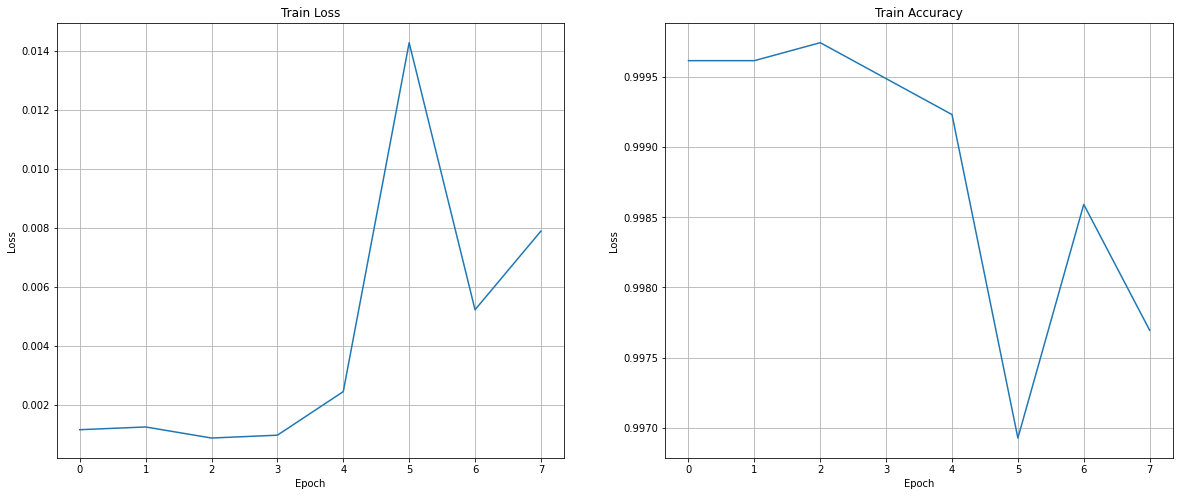

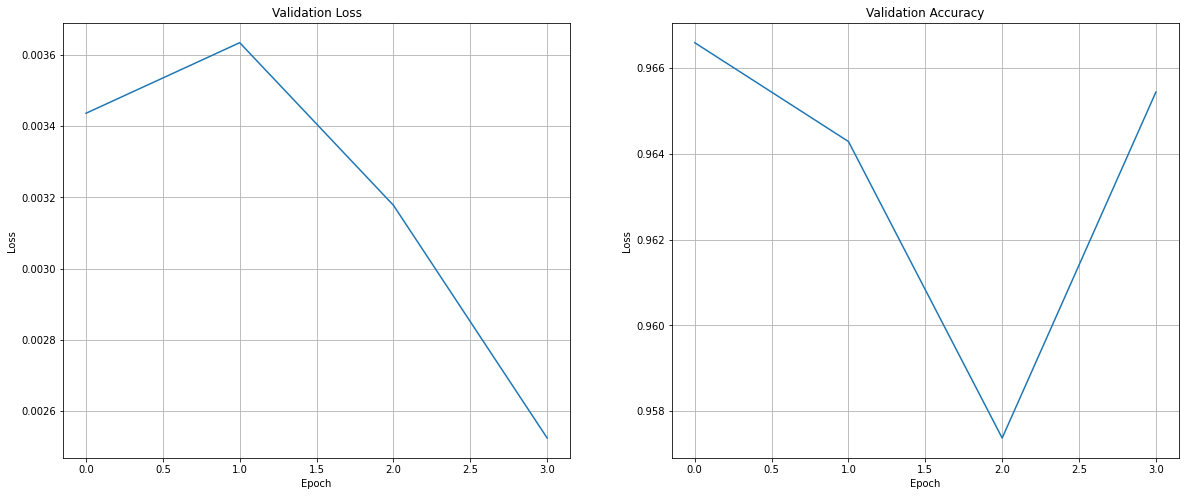

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 3:21:35 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0024, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([48,  0, 84, 36], device='cuda:0')
	Result : tensor([48,  0, 84, 36], device='cuda:0')
	TOTAL (correct/total): 839.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1423, Validation Accuracy: 96.6590 %
Epoch 3, Train Loss: 0.0013, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([ 94,   5, 100,  24], device='cuda:0')
	Result : tensor([ 94,   5, 100,  10], device='cuda:0')
	TOTAL (correct/total): 839.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1654, Validation Accuracy: 96.6590 %
Epoch 5, Train Loss: 0.0028, Train Accuracy: 99.9232 %
	 ------------------------------

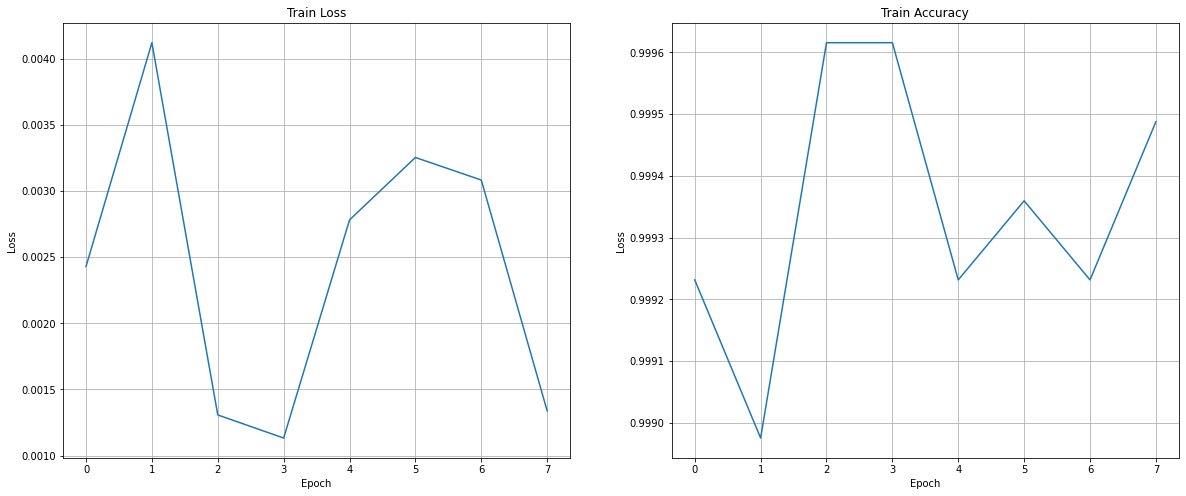

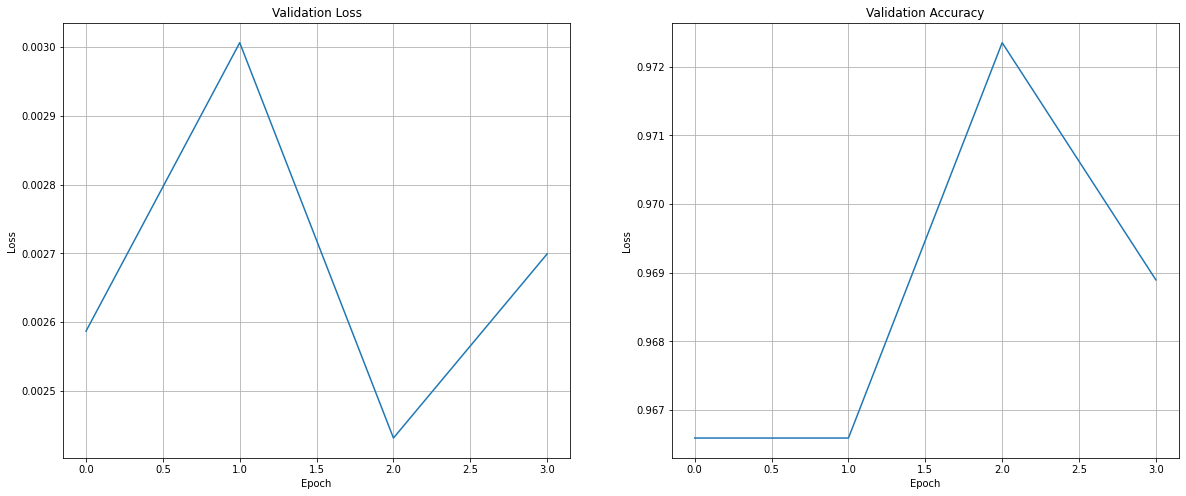

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 3:41:24 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0013, Train Accuracy: 99.9488 %
	 ----------------------------------------
	Predicted : tensor([61,  0, 95, 79], device='cuda:0')
	Result : tensor([61,  0, 60, 79], device='cuda:0')
	TOTAL (correct/total): 846.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1764, Validation Accuracy: 97.4654 %
Epoch 3, Train Loss: 0.0006, Train Accuracy: 99.9744 %
	 ----------------------------------------
	Predicted : tensor([19, 82,  0, 46], device='cuda:0')
	Result : tensor([19, 30,  0, 46], device='cuda:0')
	TOTAL (correct/total): 844.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1774, Validation Accuracy: 97.2350 %
Epoch 5, Train Loss: 0.0011, Train Accuracy: 99.9744 %
	 --------------------------------------

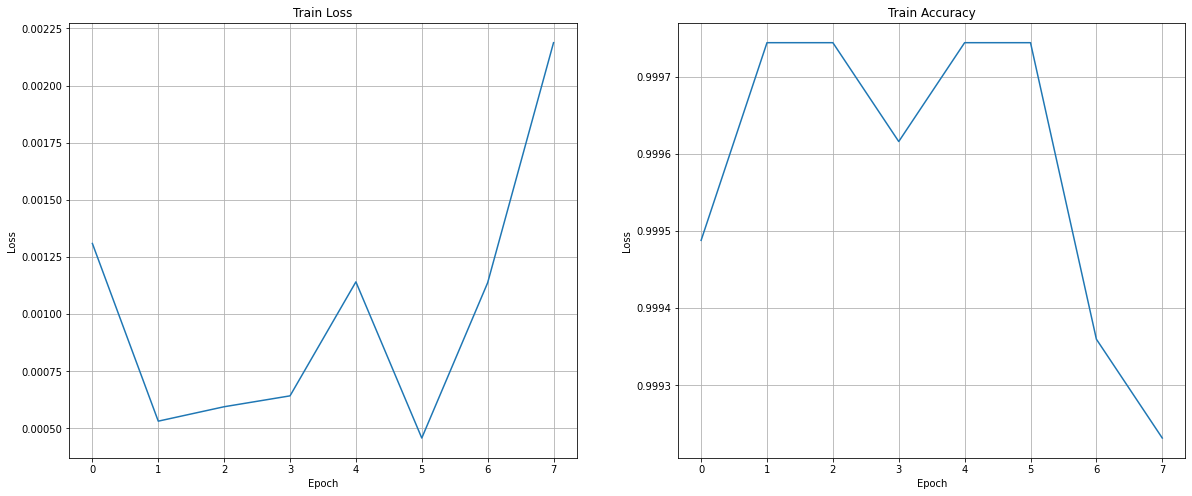

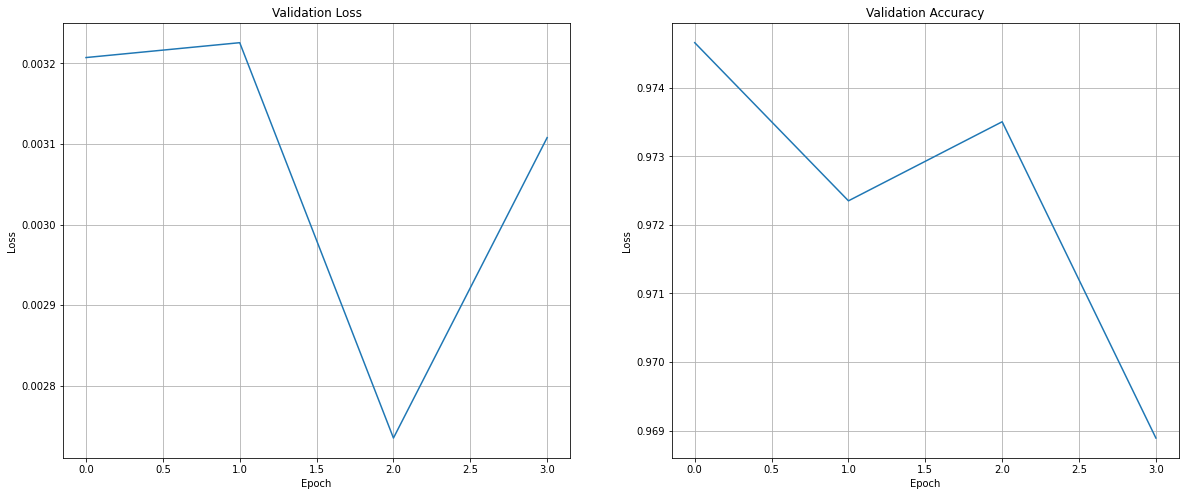

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 4:01:15 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0041, Train Accuracy: 99.8591 %
	 ----------------------------------------
	Predicted : tensor([ 5, 94, 52, 81], device='cuda:0')
	Result : tensor([ 5, 94, 52, 81], device='cuda:0')
	TOTAL (correct/total): 840.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1838, Validation Accuracy: 96.7742 %
Epoch 3, Train Loss: 0.0010, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([91, 76, 85, 32], device='cuda:0')
	Result : tensor([91, 76, 85, 32], device='cuda:0')
	TOTAL (correct/total): 841.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1646, Validation Accuracy: 96.8894 %
Epoch 5, Train Loss: 0.0010, Train Accuracy: 99.9488 %
	 --------------------------------------

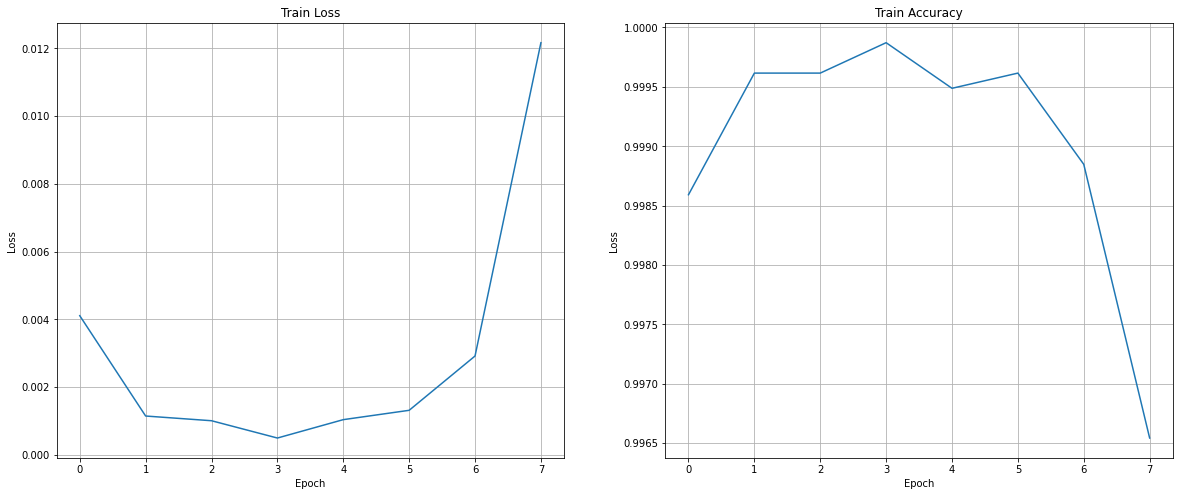

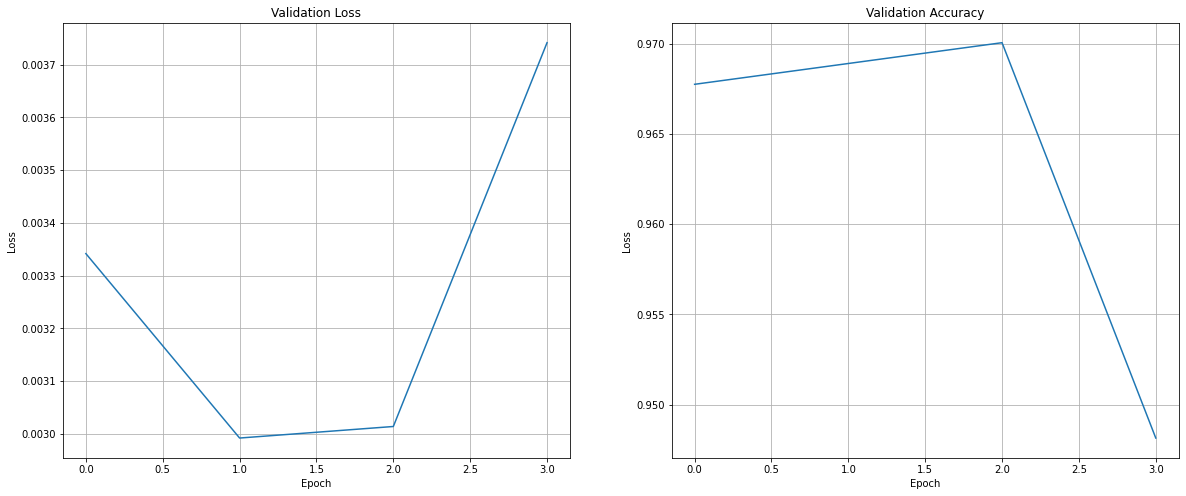

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 4:21:04 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0032, Train Accuracy: 99.8719 %
	 ----------------------------------------
	Predicted : tensor([54, 79, 76, 73], device='cuda:0')
	Result : tensor([54, 79, 76, 73], device='cuda:0')
	TOTAL (correct/total): 838.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1880, Validation Accuracy: 96.5438 %
Epoch 3, Train Loss: 0.0019, Train Accuracy: 99.9232 %
	 ----------------------------------------
	Predicted : tensor([31, 19, 12, 50], device='cuda:0')
	Result : tensor([31, 19, 12, 67], device='cuda:0')
	TOTAL (correct/total): 838.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.2360, Validation Accuracy: 96.5438 %
Epoch 5, Train Loss: 0.0038, Train Accuracy: 99.8591 %
	 --------------------------------------

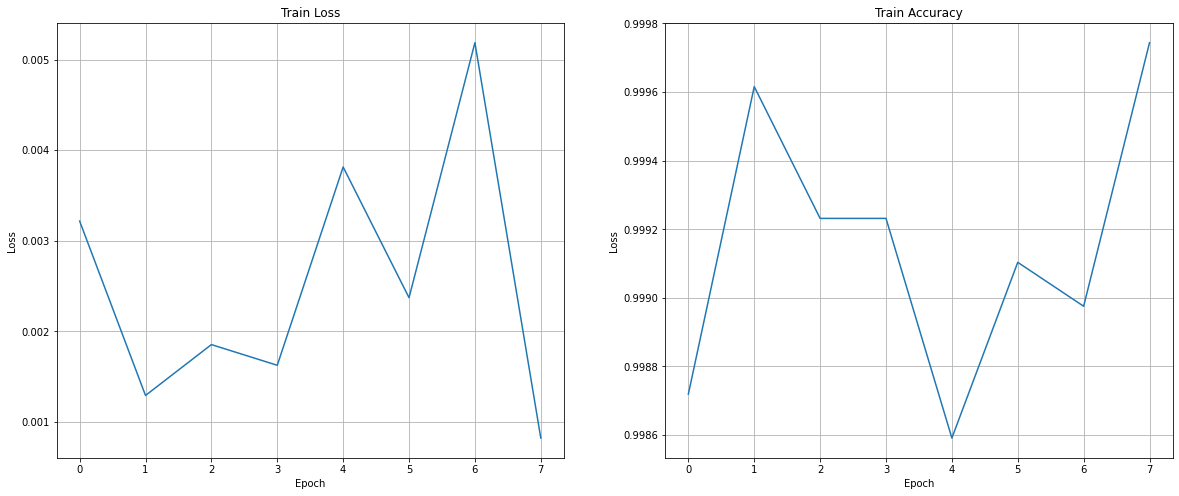

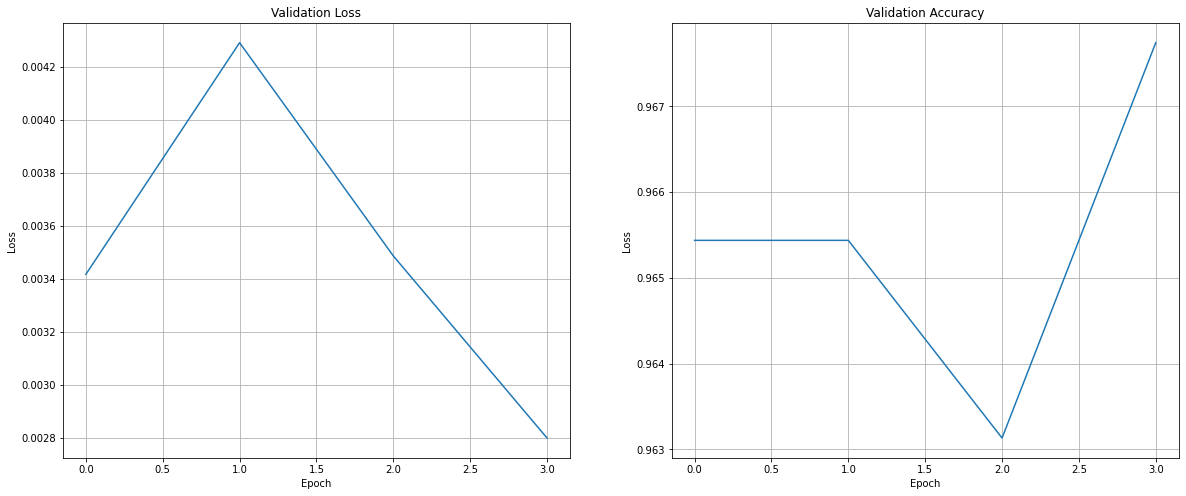

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 4:40:55 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0007, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([86,  1,  5,  5], device='cuda:0')
	Result : tensor([86,  1,  5,  5], device='cuda:0')
	TOTAL (correct/total): 841.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1702, Validation Accuracy: 96.8894 %
Epoch 3, Train Loss: 0.0008, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([39, 52,  0, 86], device='cuda:0')
	Result : tensor([39, 52,  0, 86], device='cuda:0')
	TOTAL (correct/total): 843.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1526, Validation Accuracy: 97.1198 %
Epoch 5, Train Loss: 0.0015, Train Accuracy: 99.9360 %
	 --------------------------------------

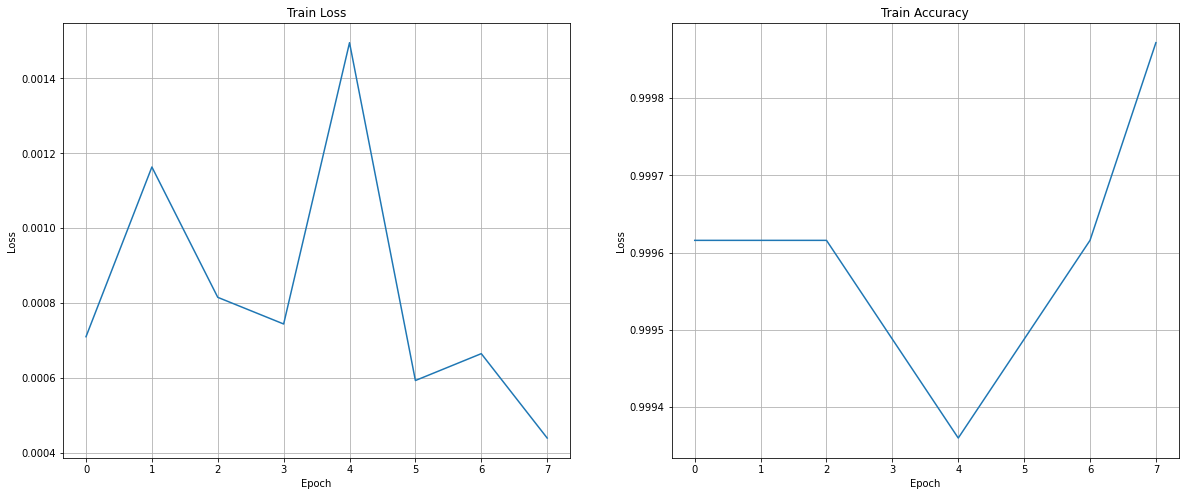

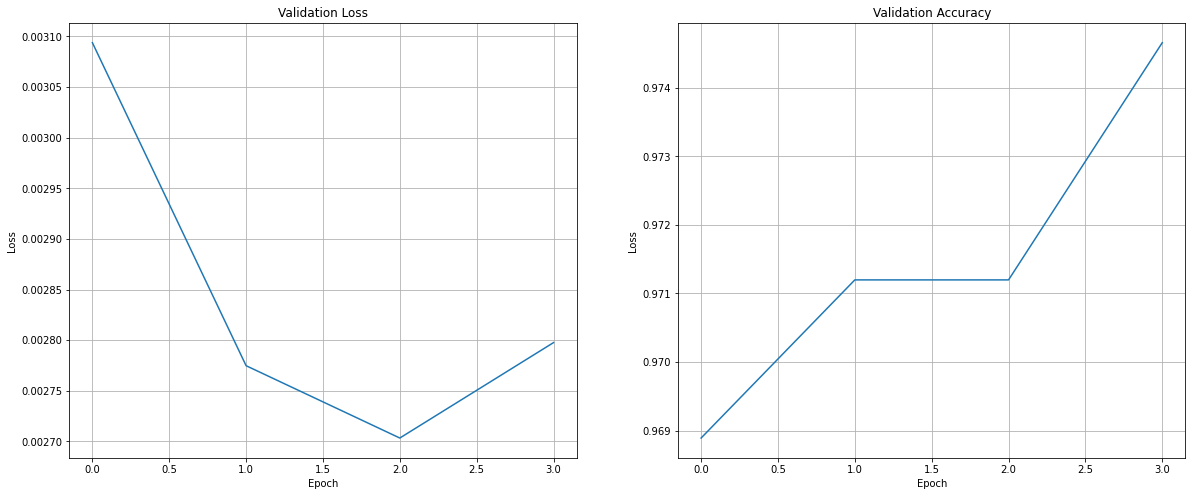

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 5:00:47 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La liste des fichiers du dossier '/content/' sur colab : ['.config', '101_ObjectCategories', '__MACOSX', 'caltech-101.zip', 'sample_data']
Device is : cuda:0

 ----------------------------------------
Epoch 1, Train Loss: 0.0006, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([36,  1, 19, 94], device='cuda:0')
	Result : tensor([36,  1, 19, 94], device='cuda:0')
	TOTAL (correct/total): 846.0 / 868.0
	 ----------------------------------------
	Epoch 2, Validation Loss: 0.1644, Validation Accuracy: 97.4654 %
Epoch 3, Train Loss: 0.0006, Train Accuracy: 99.9616 %
	 ----------------------------------------
	Predicted : tensor([20,  0,  0,  3], device='cuda:0')
	Result : tensor([20,  0,  0,  3], device='cuda:0')
	TOTAL (correct/total): 844.0 / 868.0
	 ----------------------------------------
	Epoch 4, Validation Loss: 0.1625, Validation Accuracy: 97.2350 %
Epoch 5, Train Loss: 0.0006, Train Accuracy: 99.9616 %
	 --------------------------------------

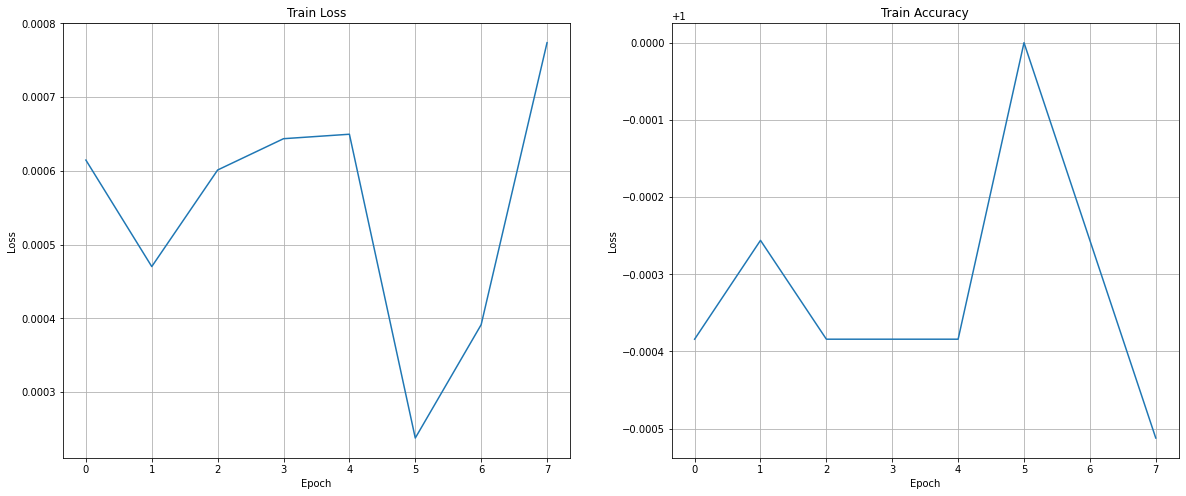

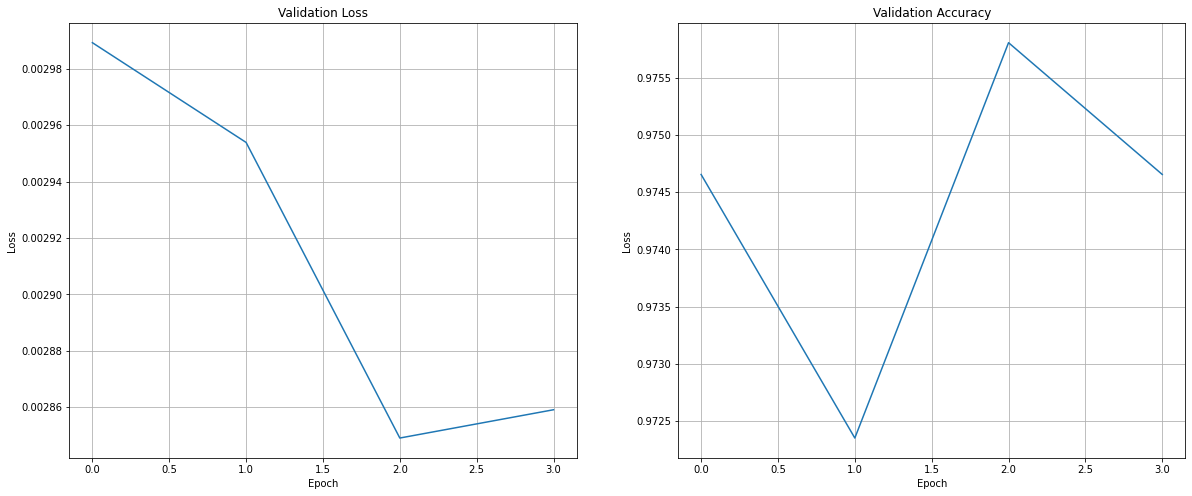

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3547), started 5:20:39 ago. (Use '!kill 3547' to kill it.)

<IPython.core.display.Javascript object>

La moyenne des accuracy: 386.1290 %


In [13]:
model_vgg16 = adapt_pretrained_model("vgg16")
loss_fn = nn.CrossEntropyLoss()
optimiseur_vgg16 = torch.optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

mean_vgg16 = boucle_de_validation_croisee_pour_k_iteration(model_vgg16, train_dataloader, test_dataloader, loss_fn, optimiseur_vgg16, epochs, typeTrain="vgg16")

## Pour le modèle densenet161 avec K = 10

In [ ]:
model_densenet161 = adapt_pretrained_model("densenet161")
loss_fn = nn.CrossEntropyLoss()
optimiseur_densenet161 = torch.optim.SGD(model_densenet161.parameters(), lr=0.001, momentum=0.9)

mean_densenet161 = boucle_de_validation_croisee_pour_k_iteration(model_densenet161, train_dataloader, test_dataloader, loss_fn, optimiseur_densenet161, epochs, typeTrain="densenet161")

## Pour le modèle inception_v3 avec K = 10

In [ ]:
model_inception_v3 = adapt_pretrained_model("inception_v3")
loss_fn = nn.CrossEntropyLoss()
optimiseur_inception_v3 = torch.optim.SGD(model_inception_v3.parameters(), lr=0.001, momentum=0.9)

mean_inception_v3 = boucle_de_validation_croisee_pour_k_iteration(model_inception_v3, train_dataloader, test_dataloader, loss_fn, optimiseur_inception_v3, epochs, typeTrain="inception_v3")

## Comparaison des moyennes des modèles

In [11]:
def compare_means_model(model_name_1, mean_model_1, model_name_2, mean_model_2):
    print("Comparaison entre les modèles : [", model_name_1, ",", mean_model_1, "] VS [", model_name_2, ",", mean_model_2, "] ")
    if mean_model_1 < mean_model_2:
        print("\n___________________________________________________\nLe Modèle", model_name_1, "est le plus performant avec une accuracy moyenne de :", mean_model_1, "!\n___________________________________________________\n")
    else:
        print("\n___________________________________________________\nLe Modèle", model_name_2, "est le plus performant avec une accuracy moyenne de :", mean_model_2, "!\n___________________________________________________\n")

#### Pour : resnet18 VS alexnet

In [12]:
compare_means_model("resnet18", mean_resnet18, "alexnet", mean_alexnet)


___________________________________________________
Le Modèle alexnet est le plus performant avec une accuracy moyenne de : 3.6375576036866355 !
___________________________________________________



#### Pour : squeezenet1_0 VS vgg16

In [ ]:
compare_means_model("squeezenet1_0", mean_squeezenet1_0, "vgg16", mean_vgg16)

#### Pour : alexnet VS squeezenet1_0

In [ ]:
compare_means_model("alexnet", mean_alexnet, "squeezenet1_0", mean_squeezenet1_0)

#### Pour : resnet18 VS vgg16

In [ ]:
compare_means_model("resnet18", mean_resnet18, "vgg16", mean_vgg16)

#### Pour : resnet18 VS densenet161

In [ ]:
compare_means_model("resnet18", mean_resnet18, "densenet161", mean_densenet161)

### Pour : densenet161 VS inception_v3

In [ ]:
compare_means_model("densenet161", mean_densenet161, "inception_v3", mean_inception_v3)